In [1]:
#%matplotlib inline
%matplotlib nbagg
import matplotlib as mpl
#matplotlib.use(u'pdf')
import numpy as np
import subprocess
from scipy import misc
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import scipy as sp
from scipy import ndimage
from scipy.stats import mode

### tiff file not working
# import tifffile
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys

import pickle
from collections import OrderedDict
from matplotlib.ticker import MaxNLocator, MultipleLocator

from scipy.ndimage import gaussian_filter

from matplotlib.animation import FuncAnimation
from matplotlib import animation

# NOT WORKING
# import ffmpy
# import ffmpeg


%matplotlib notebook


## Functions for reading  P3B data:


In [2]:
import numpy as np
from struct import pack,unpack

def IDLType(npt):
    if npt == 'uint8' or npt == 'int8': return 1
    if npt == 'int16': return 2
    if npt == 'uint16': return 12
    if npt == 'int32': return 3
    if npt == 'uint32': return 13
    if npt == 'int64': return 14
    if npt == 'uint64': return 15
    if npt == 'float32': return 4
    if npt == 'float64': return 5
    if npt == 'complex64': return 6
    if npt == 'complex128': return 9

def NPfromIDLType(vtype):
    if vtype == 1: return 'uint8'
    if vtype == 2: return 'int16'
    if vtype == 12: return 'uint16'
    if vtype == 3: return 'int32'
    if vtype == 13: return 'uint32'
    if vtype == 14: return 'int64'
    if vtype == 15: return 'uint64'
    if vtype == 4: return 'float32'
    if vtype == 5: return 'float64'
    if vtype == 6: return 'complex64'
    if vtype == 7: return 'complex128'
    
def ReadTag(f):
    klen = unpack('<l',f.read(4))[0]
    key = (f.read(klen)).decode()
    vtype,els = unpack('<ll',f.read(8))
#    print(key, vtype, els)
    if vtype ==7:
        value = (f.read(els)).decode()
    elif els == 1:
        if vtype == 1: value, = unpack('<B',f.read(1))
        elif vtype == 2: value, = unpack('<h',f.read(2))
        elif vtype == 12: value, = unpack('<H',f.read(2))
        elif vtype == 3: value, = unpack('<l',f.read(4))
        elif vtype == 13: value, = unpack('<L',f.read(4))
        elif vtype == 14: value, = unpack('<q',f.read(8))
        elif vtype == 15: value, = unpack('<Q',f.read(8))
        elif vtype == 4: value, = unpack('<f',f.read(4))
        elif vtype == 5: value, = unpack('<d',f.read(8))
    else:
        value = np.fromfile(f, dtype=NPfromIDLType(vtype), count=els)
    return key, value

def ReadP3B(filename):
    tags = {}
    with open(filename,'rb') as f:
        tagn = unpack('<l',f.read(4))[0]
        for i in range(tagn):
            key,value = ReadTag(f)
            tags[key]=value
    if 'DATA' in tags and 'DIMX' in tags and 'DIMY' in tags:
        image = tags['DATA']
        dimx = tags['DIMX']
        dimy = tags['DIMY']
        image.shape = (dimy,dimx)
    return tags
    
def WriteTag(f,key,value):
    if type(value) == float: 
        vtype = 5
        els = 1
    elif type(value) == int:
        vtype = 3
        els = 1 
    elif type(value) == str:
        vtype = 7
        els = len(value)
    elif type(value) == bool:
        vtype = 1
        els = 1
    elif type(value) == np.ndarray:
        vtype = IDLType(value.dtype)
        els = np.size(value)
    else:
        vtype = 3
        els = 1
        key = '_'+key
    f.write(pack('<l', len(key)))
    f.write(bytearray(key.upper(),'utf-8'))
    f.write(pack('<l', vtype))
    f.write(pack('<l', els))
    if key[0]=='_' and vtype ==3:
        f.write(pack('<l', 0))
    elif vtype == 5 and els == 1:
        f.write(pack('<d', value))
    elif vtype == 3 and els == 1:
        f.write(pack('<l', value)) 
    elif vtype == 1 and els == 1:
        f.write(pack('<B', value))
    elif vtype == 7:
        f.write(bytearray(value,'utf-8'))
    else:
        value.tofile(f)
        
def WriteP3B(filename, tags, image = None):
    with open(filename+'.P3B', 'wb') as f:
        if image != None:              
            f.write(pack('<l',4+len(tags)))
            (n0,n1) = np.shape(image)
            pixtype = IDLType(image.dtype)
            WriteTag(f,'DimX',n0)
            WriteTag(f,'Dimy',n1)
            WriteTag(f,'PixType',pixtype)
            WriteTag(f,'Data',image)
        else:
            f.write(pack('<l',len(tags)))
        for key in tags:
            WriteTag(f,key,tags[key])

## Analysis start here

In [ ]:
### File Selection First. Unfortunately needs to be manual

In [5]:
cd C:\Users\wills\Documents\Github\Spinon_Detector\Spinon_Data\bl11_V29c_062

C:\Users\wills\Documents\Github\Spinon_Detector\Spinon_Data\bl11_V29c_062


In [6]:
'bl11_V29c_062#000'+str(0)

'bl11_V29c_062#0000'

In [59]:
# read data --> array 'stack'
stack = []#np.zeros([80,1054,1030])
for i in range(0,200):
    if i<10:
        stack.append(ReadP3B('bl11_V29c_062#000'+str(i)+'.P3B')['DATA'])
    elif i<100:
        stack.append(ReadP3B('bl11_V29c_062#00'+str(i)+'.P3B')['DATA'])
    else:
        stack.append(ReadP3B('bl11_V29c_062#0'+str(i)+'.P3B')['DATA'])
stack = np.array(stack)
print(len(stack))

FileNotFoundError: [Errno 2] No such file or directory: 'bl11_V29c_062#0000.P3B'

<IPython.core.display.Javascript object>


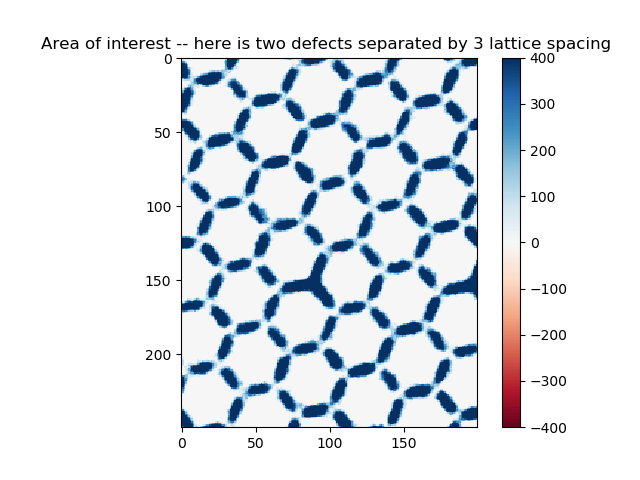

<IPython.core.display.Javascript object>


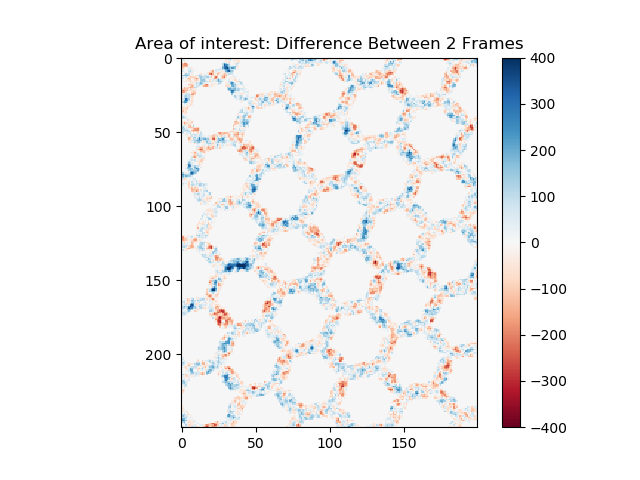

<IPython.core.display.Javascript object>


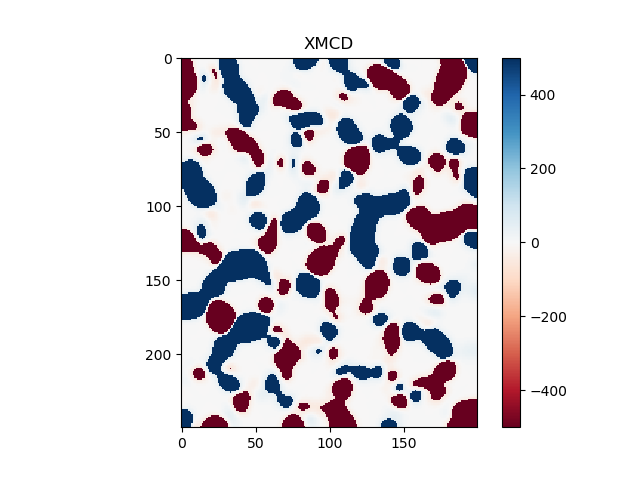

<IPython.core.display.Javascript object>


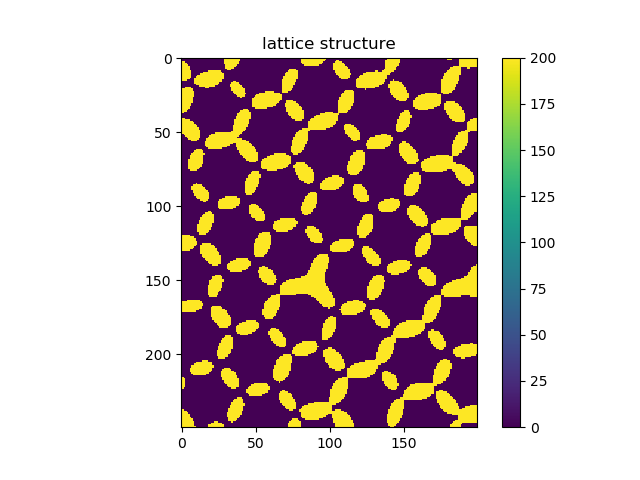

In [5]:
### This loop actually takes a while.
### stackG will be re-defined further down the line to be pre-cleaning

# correct background with graussian filter
stackG = np.zeros(stack.shape)
for i in range(stack.shape[0]):
    stackG[i] = stack[i]*1.-gaussian_filter(stack[i],20)*1.
    stackG[i][stackG[i]<0] = 0
    
#choose area of interest
stackGsub = stackG[:,400:650,400:600]

plt.figure()
plt.imshow(stackGsub[0],cmap = 'RdBu', vmin = -400, vmax = 400)
plt.title('Area of interest -- here is two defects separated by 3 lattice spacing ')
plt.colorbar()

plt.figure()
plt.imshow(stackGsub[1]-stackGsub[0],cmap = 'RdBu', vmin = -400, vmax = 400)
plt.title('Area of interest: Difference Between 2 Frames')
plt.colorbar()


# clean boundaries
for i in range(stackGsub.shape[0]):
    gf = sp.ndimage.gaussian_filter(stackGsub[i],3)
    gf[gf<1.2*gf.mean()] = 0
    stackGsub[i] = gf.copy()
    
# get XMCD image and further clearnup

# THIS IS THE SUBTRACTING STEP. ALL STEPS AFTER THIS IS CLEANING THE IMGE

stackGsubd = stackGsub.copy()
for i in range(0, stackGsub.shape[0]):
    stackGsubT = stackGsub[i]-stackGsub[0]
    stackGsubT[np.percentile(stackGsubT,95)<stackGsubT] = 1000
    stackGsubT[np.percentile(stackGsubT,5)>stackGsubT] = -1000
    stackGsubd[i] = stackGsubT.copy()


for i in range(stackGsubd.shape[0]):
    gf = sp.ndimage.gaussian_filter(stackGsubd[i], 0.5)
    gf0 = gf.copy()
    gf1 = gf.copy()
    gf0[gf<np.nanpercentile(gf,80)] = 0
    gf1[gf>np.nanpercentile(gf,20)] = 0
    stackGsubd[i] = (gf0+gf1).copy()

stackGsubd = sp.ndimage.gaussian_filter(stackGsubd, 3)
stackGsubd[stackGsubd>50] = 500
stackGsubd[stackGsubd<-50] = -500

plt.figure()
plt.imshow(stackGsubd[1], cmap = 'RdBu', vmin = -500, vmax = 500)
plt.colorbar()
plt.title('XMCD')


#get image of lattice
lattice = stackGsub[0].copy()
lattice[lattice>200] = 200
lattice[lattice<200] = 0
plt.figure()
plt.imshow(lattice)
plt.title('lattice structure')
plt.colorbar()

plt.show()

In [6]:
stackG = np.zeros(stack.shape)
for i in range(stack.shape[0]):
    stackG[i] = stack[i]*1.-gaussian_filter(stack[i],20)*1.
    stackG[i][stackG[i]<0] = 0

<IPython.core.display.Javascript object>


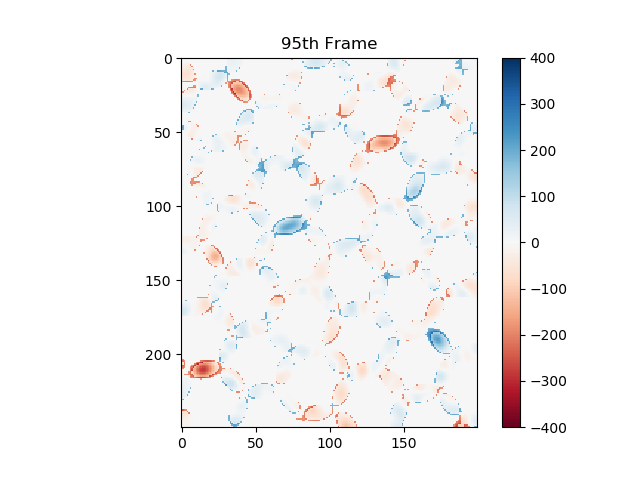

<IPython.core.display.Javascript object>


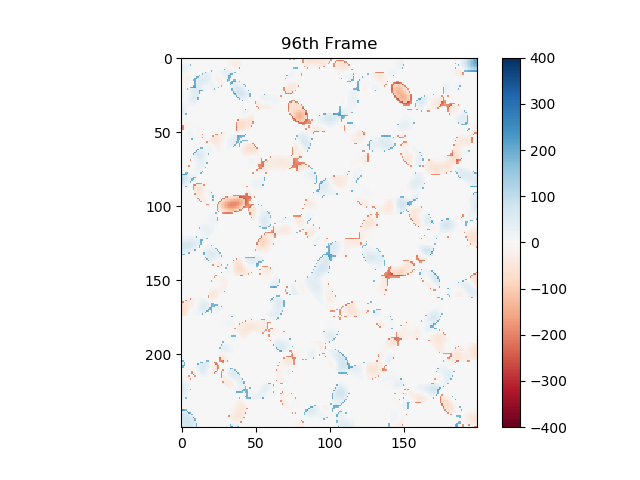

<IPython.core.display.Javascript object>


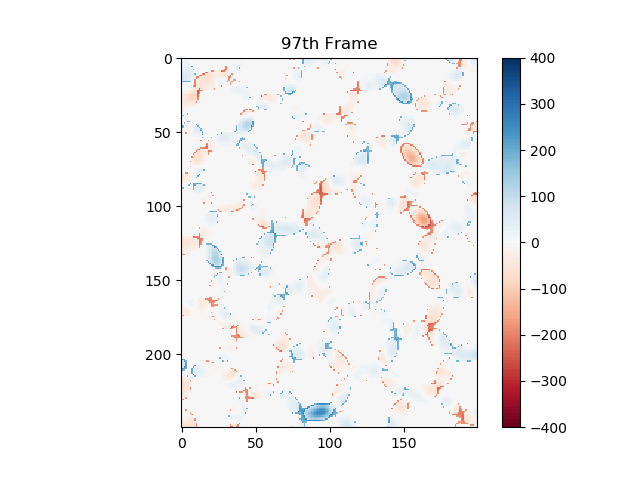

<IPython.core.display.Javascript object>


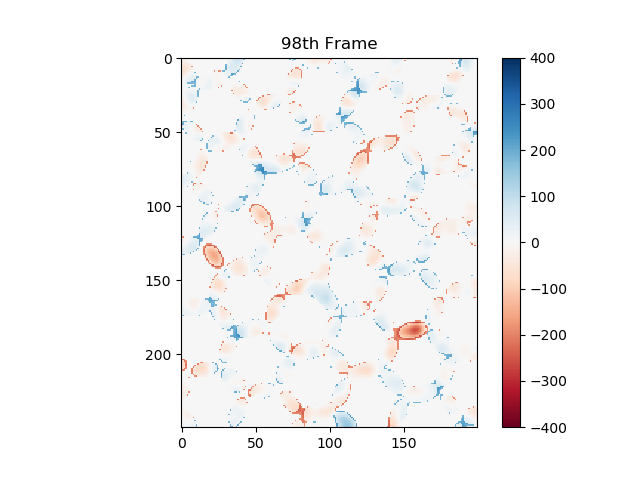

<IPython.core.display.Javascript object>


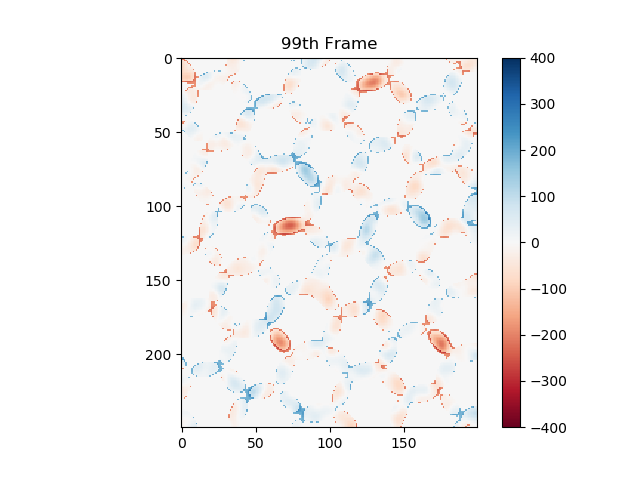

<IPython.core.display.Javascript object>


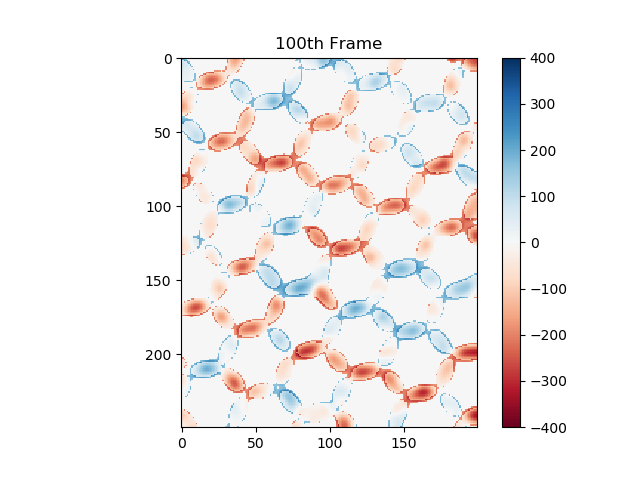

<IPython.core.display.Javascript object>


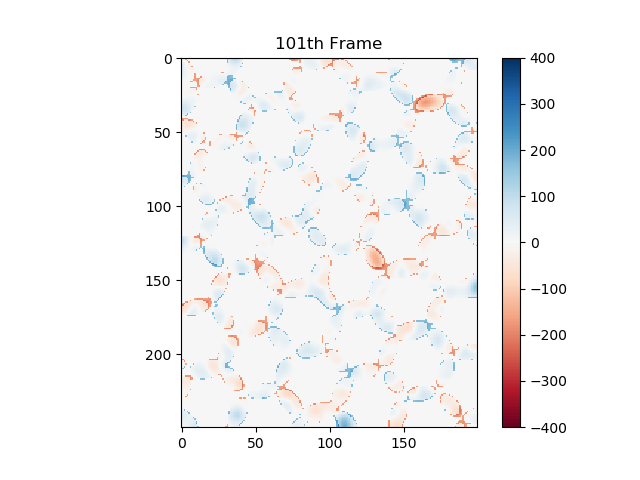

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:


for i in range(95, 105):
    diff_plot = stackGsub[i] - stackGsub[i-1]
    
    plt.figure()
    plt.imshow(diff_plot,cmap = 'RdBu', vmin = -400, vmax = 400)
    
    titlestr = str(i) + "th Frame"
    
    plt.title(titlestr)
    plt.colorbar()


In [8]:
# writing all the above into a function
def get_defects(lattice, dim = 15, tolerance = 0.7):
    '''Get approximate coordinates of the defects in a given lattice. Returns list of (y,x) coordinates for the defects
    Args:
    lattice: lattice as a normalized array 
    dim: dimensions of the square (-1) that iterates through the array
    tolerance: percentage of occupied space per square. Acts as a threshold for what squares count as defects'''
    
    defectcoords = []
    defectsums = []
    test_lat = lattice.copy()
    hdim = int(dim/2)
    
    for i in range(0,lattice.shape[0],dim):
        for j in range(0,lattice.shape[1],dim):
            total = np.sum(lattice[i:(i+dim), j:(j+dim)].sum(axis=0))
            if total >= (tolerance*dim*dim*200):
                defectcoords.append([i,j+hdim])
                defectsums.append(total)
                test_lat[i:(i+dim), j:(j+dim)] *= 5
    

    ## Process like this if cleaning wasn't involved
#     defectcoords = np.array(defectcoords)
#     defectsums = np.array(defectsums)
    
#     maxsum = np.max(defectsums)
#     maxind = np.where(defectsums == maxsum)[0][0]
#     maxcoord = defectcoords[maxind]
    
#     withoutmax = np.delete(defectsums, maxind)
#     secmax = np.max(withoutmax)
#     secind = np.where(withoutmax == secmax)[0][0]
#     seccoord = defectcoords[secind]
    
    return defectcoords

In [9]:
# with cleaning included in the lattice, the coords for the defects should be [150, 82] and [150, 187]
# or at least around those values should be ok

In [10]:
coords = get_defects(lattice)
print(coords)
startx = coords[0][0]
starty = coords[0][1]
endx = coords[1][0]
endy = coords[1][1]
#print(startx)

startendh = lattice.copy()
startendh[startx:(startx+5), starty:(starty+5)] *= 7
startendh[endx:(endx+5), endy:(endy+5)] *= 5

plt.figure()
plt.imshow(startendh)
plt.colorbar()
plt.show()

[[150, 82], [150, 187]]


<IPython.core.display.Javascript object>

35 35
35 140


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


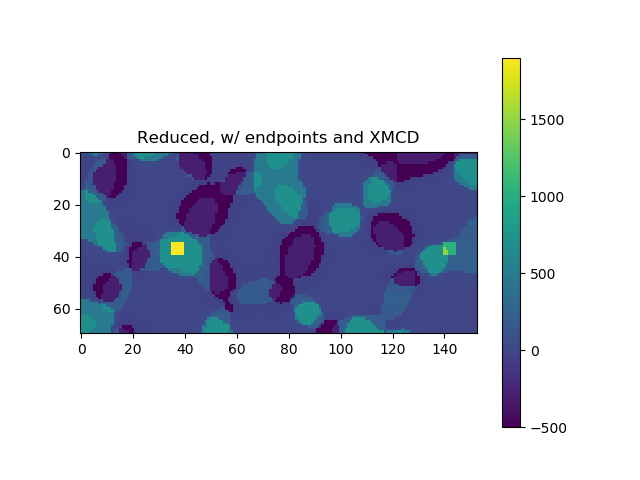

In [11]:
margin = 35
reduced = startendh[(startx - margin):(endx + margin), (starty - margin):(endy + margin)]
redstartx = np.where(reduced == 1400)[0][0]
redstarty = np.where(reduced == 1400)[1][0]
redendx = np.where(reduced == 1000)[0][0]
redendy = np.where(reduced == 1000)[1][0]
print(redstartx, redstarty)
print(redendx, redendy)
reducedXMCD = reduced + stackGsubd[1][(startx - margin):(endx + margin), (starty - margin):(endy + margin)]
plt.figure()
plt.title("Reduced, w/ endpoints")
plt.imshow(reduced)
plt.colorbar()
plt.show()
plt.figure()
plt.title("Reduced, w/ endpoints and XMCD")
plt.imshow(reducedXMCD)
plt.colorbar()
plt.show()

In [12]:
coords = get_defects(lattice)
#print(coords)
startx = coords[0][0]
starty = coords[0][1]
endx = coords[1][0]
endy = coords[1][1]
#print(startx)

startendh = lattice.copy()
startendh[startx, starty] *= 7
startendh[endx, endy] *= 5

margin = 35
reduced = startendh[(startx - margin):(endx + margin), (starty - margin):(endy + margin)]

# finding the coordinates again, for the reduced mapping
redstartx = np.where(reduced == startendh[startx, starty])[0][0]
redstarty = np.where(reduced == startendh[startx, starty])[1][0]

redendx = np.where(reduced == startendh[endx, endy])[0][0]
redendy = np.where(reduced == startendh[endx, endy])[1][0]

redstart = [redstartx, redstarty]
redend = [redendx, redendy]

# print(redstart)
reduced[redstartx, redstarty] /= 7
reduced[redendx, redendy] /= 5

print(redstart)
print(redend)

[35, 35]
[35, 140]


In [13]:
def get_nodes(larray, given_start, end, dim = 15, tol = 0.8):
    
    #first node is the start, so
    nodes = []
    
    plot = larray.copy()
    hdim = int(dim/2)
    fdim = int(dim/4)
    
    start = given_start.copy()
    plot[(start[0]):(start[0] + hdim), (start[1]):(start[1] + hdim)] = 500
    #plot[(end[0]):(end[0] + hdim), (end[1]):(end[1] + hdim)] *= 5
    
    xdiff = np.abs(start[0] - end[0])
    ydiff = np.abs(start[1] - end[1])
    
    while np.abs(start[0] - end[0]) >= dim or np.abs(start[1] - end[1]) >= dim:
        
        origins = [] 

        # REDOING CONVENTION AGAIN: +x = up -> down direction, +y = left -> right direction
        pos_x = [(start[0]+dim),start[1]]
        # pos_x_mode = mode(plot[(start[0]:pos_x[0]), (start[1]:pos_x[1])], axis = None) 
        neg_y_pos_x = [(start[0]+dim),(start[1]-dim)]
        pos_y_pos_x = [(start[0]+dim),(start[1]+dim)]
        
        pos_y = [start[0],(start[1]+dim)]
        neg_x_pos_y = [(start[0]-dim),(start[1]+dim)]
        # +x +y redundant with +y +x
        # pos_x_pos_y = [(start[0]+dim),(start[1]+dim)]
        
        # Fine tuning?
        
        # NEED TO FLIP TO lower:higher order
#         pypx_plt = plot[start[0]:pos_y_pos_x[0], start[1]:pos_y_pos_x[1]]
#         nxpy_plt = plot[neg_x_pos_y[0]:start[0], start[1]:neg_x_pos_y[1]]
#         py_plt = plot[start[0]:pos_y[0], start[1]:pos_y[1]]
        
#         pypx_mode = mode(pypx_plt, axis = None)
#         nxpy_mode = mode(nxpy_plt, axis = None)
#         py_mode = mode(py_plt, axis = None)
#         print('pos y pos x mode:', pypx_mode)
#         print('neg x pos y mode:', nxpy_mode)
#         print('py mode:', py_mode)
    
#         if len(nxpy_mode[0]) == 0:
#             print(neg_x_pos_y[0])
#             print(start)
#             print(plot[start[0]:neg_x_pos_y[0], start[1]:neg_x_pos_y[1]]
        
        if xdiff > ydiff:
            origins = [pos_x, neg_y_pos_x, pos_y_pos_x]
        else:
            origins = [pos_y, neg_x_pos_y, pos_y_pos_x]
        
        fracs = []
        poss_step = []
        
        ## fractions method
        for origin in origins:
            x = origin[0]
            y = origin[1]
            sub = larray[x:(x+hdim), y:(y+hdim)]
            subtot = np.sum(sub).sum(axis=0)
            frac = subtot/(dim*dim*200)
            fracs.append(frac)
            
            if (frac >= tol and origin not in nodes):
                poss_step.append(origin)
                #print("frac method +1")
        
        if fracs == list(np.zeros(len(fracs))):
            break
        
        ## Scanning method: scan perpendicular to main direction
        scans = []
        adjacent = []
        x = start[0]
        y = start[1]
        
        if ydiff > xdiff:
            for k in range(1,3):
                for i in range((-dim),(dim + 1)):
                    scan = [(x + i), (y + hdim*k)]
                    #print(scan)
                    sub = larray[scan[0]:(scan[0] + hdim), scan[1]:(scan[1] + hdim)]
                    #print(sub)
                    subtot = np.sum(sub).sum(axis=0)
                    frac = subtot/(hdim*hdim*200)
                    #print(subtot)
                    if frac >= tol and scan[0] >= 0 and scan[1] >= 0:
                        scans.append(scan)
                        
                        # check for adjacent:
                        if k == 1 and np.abs(i) <= hdim:
                            adjacent.append(scan)
                        
                        
        elif xdiff > ydiff:
            for k in range(1,3):
                for i in range((-dim),(dim + 1)):
                    scan = [(x + hdim*k), (y + i)]
                    #print(scan)
                    sub = larray[scan[0]:(scan[0] + hdim), scan[1]:(scan[1] + hdim)]
                    #print(sub)
                    subtot = np.sum(sub).sum(axis=0)
                    frac = subtot/(hdim*hdim*200)
                    #print(subtot)
                    if frac >= tol and scan[0] >= 0 and scan[1] >= 0:
                        scans.append(scan)
        
        if len(scans) == 0:
            nodes = []
            start = given_start.copy()
            plot = larray.copy()
            plot[(start[0]):(start[0] + hdim), (start[1]):(start[1] + hdim)] = 500
            print('Bad path, restarting...')
            continue
        
        #print(scans)
        rand_scan_ind = np.random.randint(0, len(scans))
        #print("Adjacent:", adjacent)
        scanned_start = np.zeros(2)
        scanned_start[0] = scans[rand_scan_ind][0]
        scanned_start[1] = scans[rand_scan_ind][1]
        #print('choice:',scanned_start)
        #if scanned_start in np.array(adjacent):
            #print("That's adjacent")
        
#         jump = False
#         if (scanned_start[1] - start[1] >= 2*hdim):
#             jump = True
#             #print(start[1])
#             #print(scanned_start[1])
#             #print('jumped')
        
        # if none of the paths pass the tolerance test, then pick maximum valued choice
        maxes = np.where(np.max(fracs) == fracs)[0]
        if len(maxes) == 1:
            max_ind = int(np.where(np.max(fracs) == fracs)[0])
        else:
            rand = np.random.randint(len(maxes))
            max_ind = int(np.where(np.max(fracs) == fracs)[0][rand])
        
        
        if len(poss_step) == 0:
            max_frac_ind = np.where(np.max(fracs) == fracs)
            poss_step.append(origins[max_frac_ind[0][0]])
            #print(maxes)
            #print('max method +1')
            
        #ultimatum to make path fully connect
        if ydiff > xdiff:
            for step in poss_step:
                if (step[0] - end[0] >= dim) and (end[1] - step[1] <= 2*dim):
                    poss_step = [neg_x_pos_y]
                if (step[0] - end[0] <= -1*dim) and (end[1] - step[1] <= 2*dim):
                    poss_step = [pos_y_pos_x]
                    #print('forced method +1')
        
        
        
        #print("Possible steps:", poss_step)
        rand_ind = np.random.randint(0, len(poss_step))
        #print('randint', rand_ind)
        start[0] = poss_step[rand_ind][0]
        start[1] = poss_step[rand_ind][1]
        
        
        # fine tuning step
        start_mode = mode(plot[(start[0]):(start[0] + hdim), (start[1]):(start[1] + hdim)], axis = None)
        
        start[0] = int(scanned_start[0])
        start[1] = int(scanned_start[1])
        
        
        nodes.append([start[0],start[1]])
        
        
#         plot[(start[0]):(start[0] + hdim), (start[1]):(start[1] + hdim)] = 500
    avgednodes = []
    for i in range(len(nodes) - 1):
        nodexdiff = nodes[i+1][0] - nodes[i][0]
        nodeydiff = nodes[i+1][1] - nodes[i][1]
        
        if np.abs(nodeydiff) <= (hdim+fdim) and np.abs(nodexdiff) <= hdim:
            avgx = int((nodes[i][0] + nodes[i+1][0])/2)
            avgy = int((nodes[i][1] + nodes[i+1][1])/2)
            
            nodes[i][0] = avgx
            nodes[i+1][0] = avgx
            nodes[i][1] = avgy
            nodes[i+1][1] = avgy
            
            avgednodes.append([avgx,avgy])
        
    
    for node in nodes:
        plot[(node[0]):(node[0] + hdim), (node[1]):(node[1] + hdim)] = 500
    
    plt.figure()
    plt.title("Path with nodes")
    plt.imshow(plot)
    plt.colorbar()
    
    plt.show()
    
    return nodes

<IPython.core.display.Javascript object>


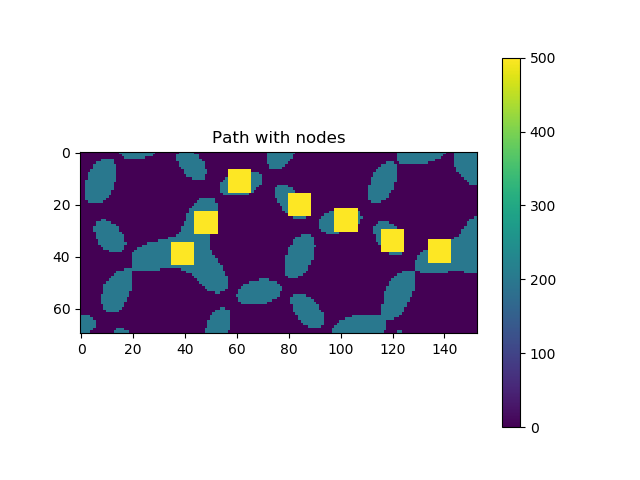

[[23, 44], [7, 57], [7, 57], [16, 80], [22, 98], [30, 116], [34, 134]]


<IPython.core.display.Javascript object>


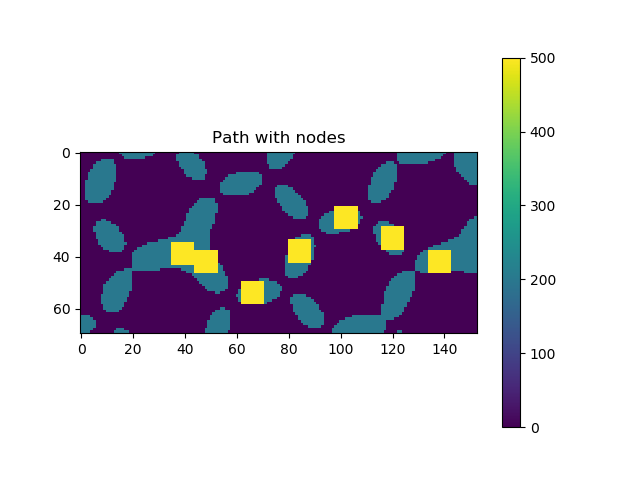

[[38, 44], [50, 62], [34, 80], [21, 98], [29, 116], [38, 134]]


<IPython.core.display.Javascript object>


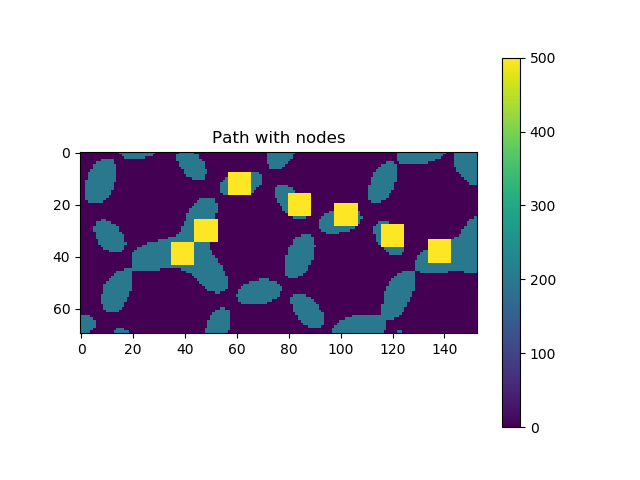

[[26, 44], [8, 57], [8, 57], [16, 80], [20, 98], [28, 116], [34, 134]]


C:\Users\wills\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


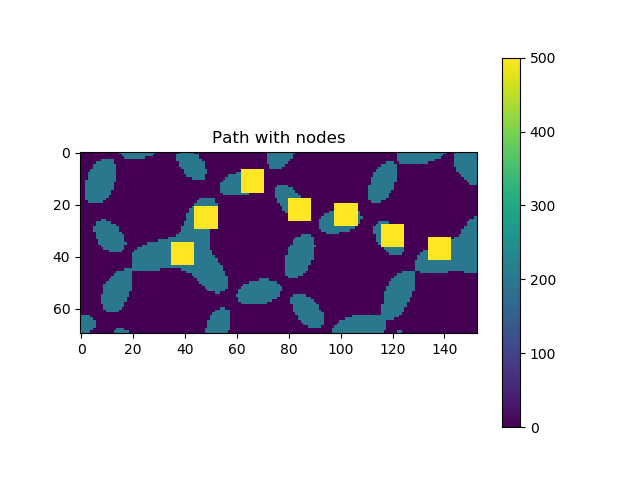

[[21, 44], [7, 62], [18, 80], [20, 98], [28, 116], [33, 134]]


<IPython.core.display.Javascript object>

[[33, 44], [50, 62], [39, 80], [24, 98], [27, 116], [33, 134]]


<IPython.core.display.Javascript object>

[[19, 44], [8, 62], [18, 80], [20, 98], [32, 116], [33, 134]]


<IPython.core.display.Javascript object>

[[34, 44], [49, 62], [32, 80], [24, 98], [27, 116], [38, 134]]


<IPython.core.display.Javascript object>

[[26, 44], [8, 57], [8, 57], [18, 80], [20, 98], [30, 116], [33, 134]]


<IPython.core.display.Javascript object>

[[23, 44], [7, 57], [7, 57], [16, 80], [22, 98], [32, 116], [34, 134]]


<IPython.core.display.Javascript object>

[[41, 44], [48, 62], [36, 80], [22, 98], [32, 116], [35, 134]]


<IPython.core.display.Javascript object>

[[42, 44], [51, 62], [38, 80], [20, 98], [32, 116], [34, 134]]


<IPython.core.display.Javascript object>

[[45, 44], [52, 62], [34, 80], [20, 98], [31, 116], [34, 134]]


<IPython.core.display.Javascript object>

[[35, 44], [49, 62], [41, 80], [23, 98], [27, 116], [40, 134]]


<IPython.core.display.Javascript object>

[[23, 44], [7, 62], [18, 80], [23, 98], [28, 116], [37, 134]]


<IPython.core.display.Javascript object>

[[39, 44], [51, 62], [41, 80], [24, 98], [32, 116], [40, 134]]


<IPython.core.display.Javascript object>

[[37, 44], [48, 62], [39, 80], [21, 98], [31, 116], [38, 134]]
Bad path, restarting...


<IPython.core.display.Javascript object>

[[41, 44], [52, 62], [41, 80], [24, 98], [31, 116], [40, 134]]


<IPython.core.display.Javascript object>

[[42, 44], [49, 62], [39, 80], [24, 98], [28, 116], [35, 134]]


<IPython.core.display.Javascript object>

[[41, 44], [51, 62], [40, 80], [24, 98], [32, 116], [36, 134]]


<IPython.core.display.Javascript object>

[[41, 44], [49, 62], [33, 80], [21, 98], [31, 116], [36, 134]]


In [14]:
for i in range(0,20):
    nodes = get_nodes(reduced, redstart, redend, dim = 18, tol = 0.7)
    print(nodes)

In [15]:
eroded1 = ndimage.grey_erosion(reduced.copy(), size=(4,4))
#eroded2 = ndimage.grey_erosion(eroded1, size=(3,3))
plt.figure()
plt.imshow(eroded1)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

In [16]:
redstartx

35

In [17]:
# Blots out "center" of starting defect, so the paths are calculated from the edges

modified_eroded = eroded1.copy()
modified_eroded[redstartx:(redstartx + 15) , redstarty:(redstarty + 15)] = 0
plt.figure()
plt.imshow(modified_eroded)
plt.show()

<IPython.core.display.Javascript object>

In [18]:
def generate_island_dict(larray):
   
    nonzeros = np.argwhere(larray != 0)
    #print("len(nonzeros) = ", len(nonzeros))
    larrayx = larray.shape[0]
    larrayy = larray.shape[1]
   
    disclude = []
    island_dict = {}
   
    testagain = larray
    
    for i in range(len(nonzeros)):
        
        # print("Current Progress:", i)
        
        currentx = nonzeros[i][0]
        currenty = nonzeros[i][1]
        xiter = currentx
        yiter = currenty
       
        if [currentx,currenty] not in disclude:
       
            current_island_array = []
            value = testagain[xiter][yiter]
            
            # Iterate downward through the rows
            while value != 0:
                
                trigger = False
                
                lefts = [yiter]
                
                ### Check left:
                while value != 0:
                    if [xiter, yiter] not in disclude:
    
                        disclude.append([xiter,yiter])
                        current_island_array.append([xiter,yiter])

                        yiter -= 1

                        if yiter <= 0:
                            yiter = 0
                        
                        lefts.append(yiter)

                    else:
                        break

                    value = testagain[xiter][yiter]
                ###        
                   
                   
                ### Check right
                # if at very right, then do nothing
                
                if currenty < (larrayy - 1):
                    
                    yiter = currenty + 1
                    
                    value = testagain[xiter][yiter]
                    
                    rights = [yiter]
                    
                    while value != 0:
                        
                        if [xiter, yiter] not in disclude:

                            disclude.append([xiter,yiter])
                            current_island_array.append([xiter,yiter])

                            yiter += 1

                            if yiter >= (larrayy - 1):
                                yiter = larrayy - 1

                            rights.append(yiter)
                            
                        else:
                            break    

                        value = testagain[xiter][yiter]
                ###
                
                lefts.reverse()
#                     print('Lefts', lefts)
#                     print('rights', rights)
                total_row = lefts + rights
                #print("full row: ", total_row)
                row_arr = np.array(total_row)
#                 row_avg = np.average(row_arr)
                    
                    
                ### Move to the next row
                xiter += 1
               
                if xiter >= (larrayx -1):
                    xiter = larrayx -1
               
                
                yiter = currenty
                
                ### Below fixes the "Diagonal problem"
                
                # check exactly 1 row down from original y-value
                if [xiter, yiter] not in disclude:
                    value = testagain[xiter][yiter]
                    
                    # if that's zero, scan the previous row, and check if those points have adjacent nonzeros
                    
                    if value == 0:
                        for y_value in total_row:
                            sub_val = testagain[xiter][y_value]
                            
                            # if a nonzero is found, that will be the new starting point of the next row
                            
                            if sub_val != 0:
                                yiter = y_value
                                if [xiter, yiter] not in disclude:
                                    value = testagain[xiter][yiter]
                                
                                continue
                    
                else:
                    break
            
            ### Now go back upwards, iterating with same process
            ### Note: definitely brute forced; could probably shorten the code length by ~1/2
            ### However, runtime increase is defintely < 2*origina rate still
            
            xiter = currentx
            yiter = currenty
            value = testagain[xiter][yiter]
            
            while value != 0:
                
                lefts = [yiter]
                
                ### Check left:
                while value != 0:
                    #testagain[xiter][yiter] *= 5
                    
                    if [xiter, yiter] not in disclude:
                   
                        disclude.append([xiter,yiter])
                        current_island_array.append([xiter,yiter])

                        yiter -= 1

                        if yiter <= 0:
                            yiter = 0
                        
                        lefts.append(yiter)

                    else:
                        break

                    value = testagain[xiter][yiter]
                ###         
                   
                ### Check right
                # if at very right, then do nothing
                if currenty < (larrayy - 1):
                    
                    yiter = currenty + 1
                    value = testagain[xiter][yiter]
                    
                    rights = [yiter]
                    
                    while value != 0:
                        #testagain[xiter][yiter] *= 5
                        
                        
                        if [xiter, yiter] not in disclude:

                            disclude.append([xiter,yiter])
                            current_island_array.append([xiter,yiter])

                            yiter += 1

                            if yiter >= (larrayy - 1):
                                yiter = larrayy - 1

                            rights.append(yiter)
                            
                        else:
                            break    

                        value = testagain[xiter][yiter]
                        
                lefts.reverse()
#                     print('Lefts', lefts)
#                     print('rights', rights)
                total_row = lefts + rights
                #print("full row: ", total_row)
                row_arr = np.array(total_row)
                row_avg = np.average(row_arr)
                    
                    
                ### Move to the next row
                xiter -= 1
               
                if xiter <= 0:
                    xiter = 0
               
                
                yiter = currenty
                
                ### Below fixes the "Diagonal problem"
                
                # check exactly 1 row down from original y-value
                if [xiter, yiter] not in disclude:
                    value = testagain[xiter][yiter]
                    
                    # if that's zero, scan the previous row, and check if those points have adjacent nonzeros
                    
                    if value == 0:
                        for y_value in total_row:
                            sub_val = testagain[xiter][y_value]
                            
                            # if a nonzero is found, that will be the new starting point of the next row
                            
                            if sub_val != 0:
                                yiter = y_value
                                if [xiter, yiter] not in disclude:
                                    value = testagain[xiter][yiter]
                                
                                continue
                    
                else:
                    break
            
            #print('Array len:', len(current_island_array))
            
            avg_coord = np.mean(current_island_array, axis = 0)
            avg_coord[0] = int(avg_coord[0])
            avg_coord[1] = int(avg_coord[1])
            avg_coord = (avg_coord[0], avg_coord[1])
            island_dict[avg_coord] = current_island_array
            
            ### "Hard-coded" value for minimum array size to count as an island. May vary.
            if len(current_island_array) < 25:

                other_keyvals = []
                distances = []
                if len(island_dict.keys()) != 1:
                    for key in island_dict.keys():
                        if key != avg_coord:
                            other_keyvals.append(key)
                            distance = np.sqrt( (key[0] - avg_coord[0])**2 + (key[1] - avg_coord[1])**2 )
                            distances.append(distance)
                    
                    min_dist_ind = np.argwhere(distances == np.min(distances))[0][0]
                    replacement_key = other_keyvals[min_dist_ind]

                    island_dict[replacement_key] = island_dict[replacement_key] + island_dict[avg_coord]
                    del island_dict[avg_coord]
       
    return island_dict

In [19]:
eroded_dict = generate_island_dict(eroded1.copy())


In [20]:
reduced_dict = generate_island_dict(reduced.copy())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


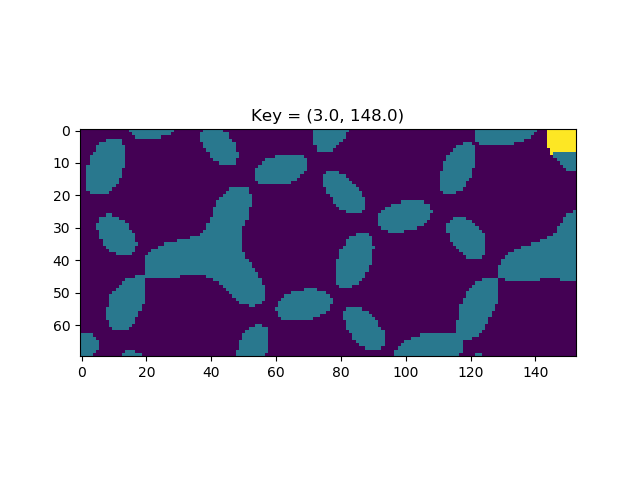

<IPython.core.display.Javascript object>


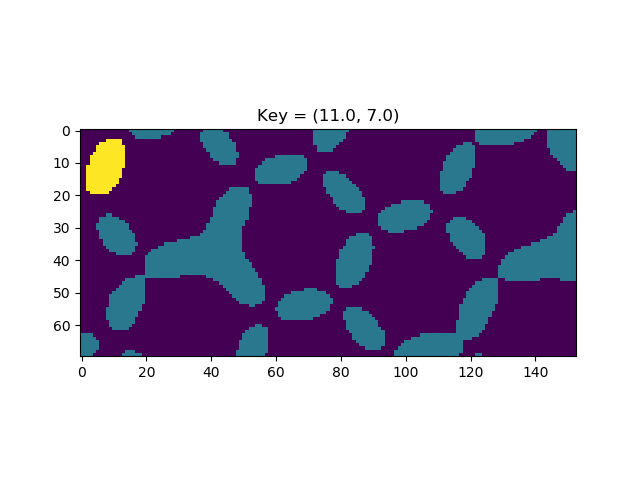

<IPython.core.display.Javascript object>


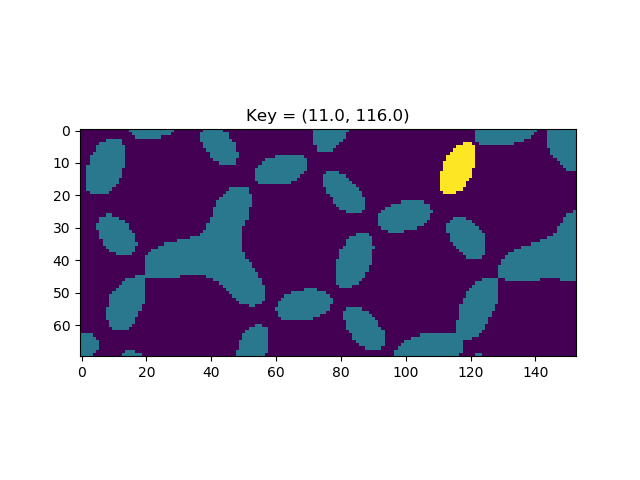

<IPython.core.display.Javascript object>


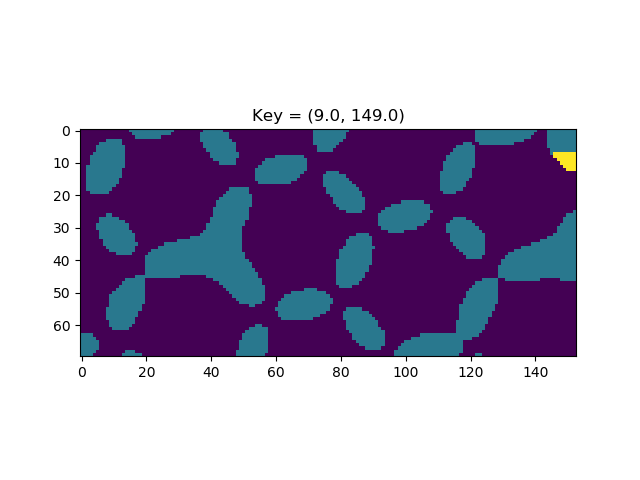

<IPython.core.display.Javascript object>


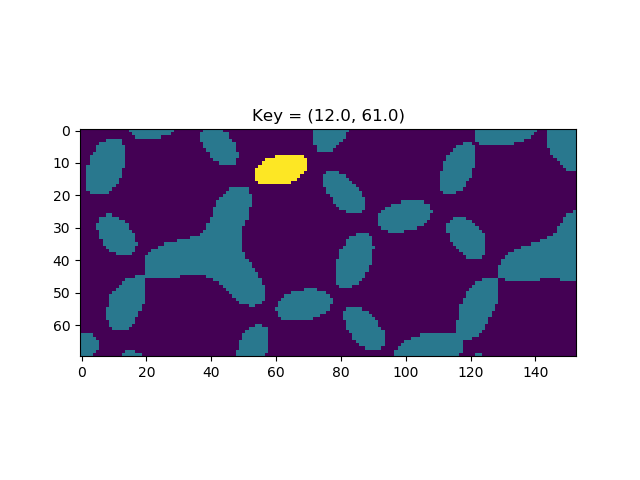

<IPython.core.display.Javascript object>


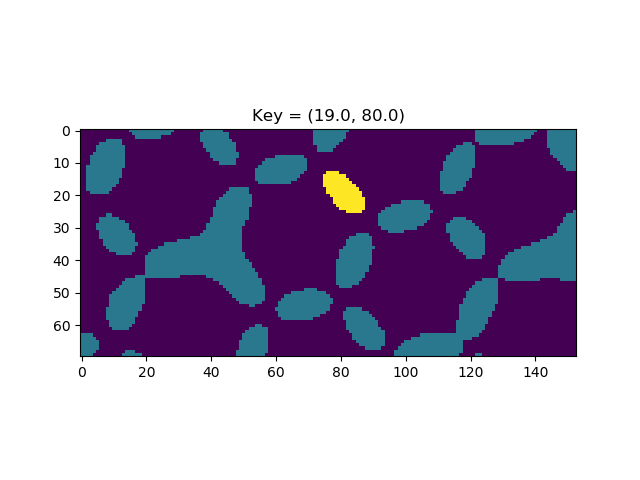

<IPython.core.display.Javascript object>


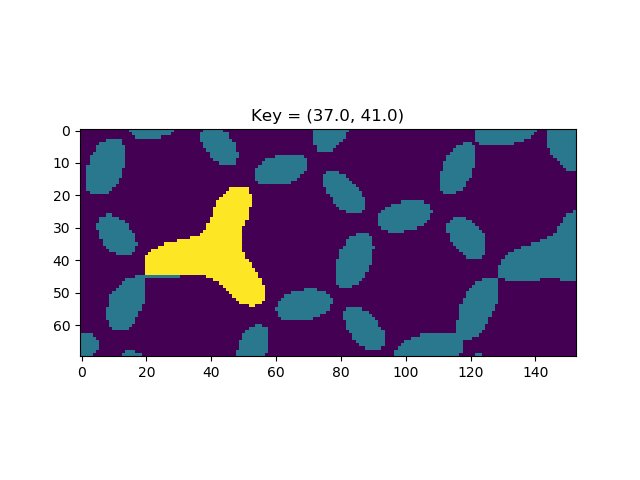

<IPython.core.display.Javascript object>


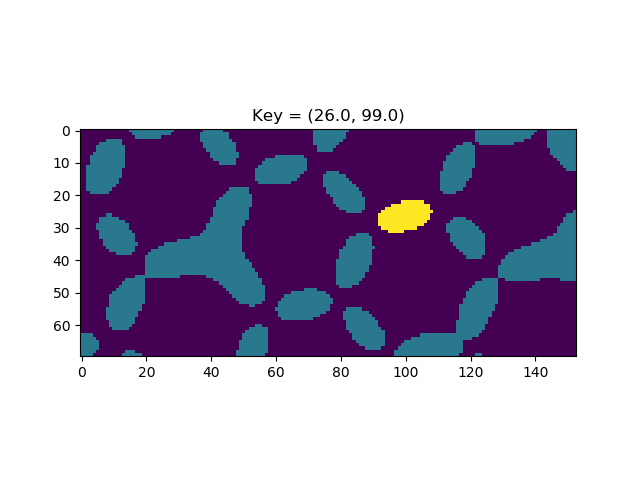

<IPython.core.display.Javascript object>


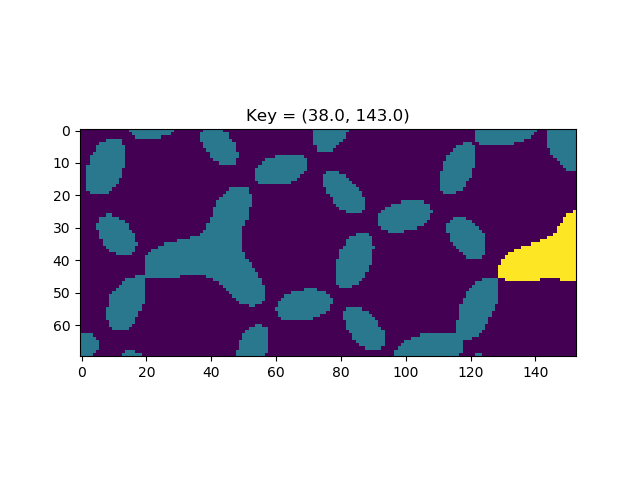

<IPython.core.display.Javascript object>


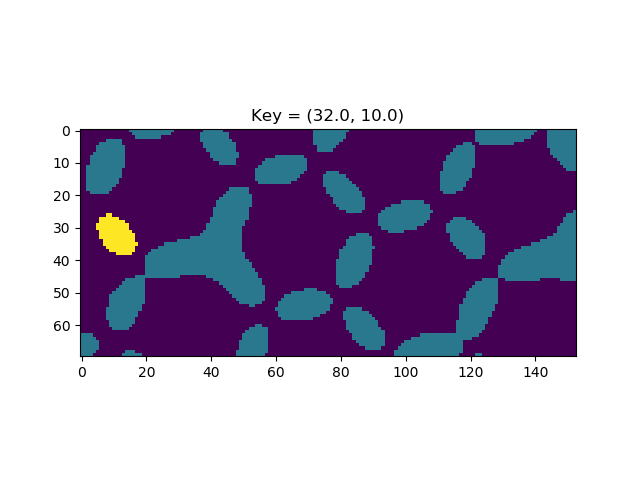

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# for un-modified eroded 
keylist = []
for key in reduced_dict.keys():
    keylist.append(key)

for key in keylist:
    a2 = reduced.copy()
    currentcoords = reduced_dict[key]
    for coord in currentcoords:
        a2[coord[0], coord[1]] = 500
    
    plt.figure()
    title = 'Key = ' + str(key)
    plt.title(title)
    plt.imshow(a2)

plt.show()

In [22]:
#####

### CHECK THIS LINE FOR WHAT TYPE OF DICT
current_dict = eroded_dict

#####

In [23]:
# specific params to make this work:
# last "if len(current island)" < 25 of "generate island dict"
# +/- "margin" for "reduced definition" = 35
# "eroded1" erosion = (4,4)

mod_dict = generate_island_dict(modified_eroded.copy())

In [24]:
# for modified eroded
mkeylist = []
for m in mod_dict.keys():
    mkeylist.append(m)

In [25]:
for key in mkeylist:
    a2 = modified_eroded.copy()
    currentcoords = mod_dict[key]
    for coord in currentcoords:
        a2[coord[0], coord[1]] = 500
    
    if key == (27, 45) or key == (48, 51):
        plt.figure()
        title = 'Key = ' + str(key)
        plt.title(title)
        plt.imshow(a2)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# redone so many times, might as well define it. adding the "N" component helps a lot actually.
# tolerance for how far an island gets before it can't be inside the "minimum" distance value anymore
def min_dist_keys(givenkey, givenkeylist, N = 1, tolerance = 30):
    '''
    givenkey = tuple, coordinate
    givenkeylist = list of tuples, list of keys of dictionary
    N = number of closest keys wanted, in ascending distance order (i.e. minimum distance first)
    - can't be longer than the givenkeylist
    
    returns LIST of nearest key(s) from keylist to the given key (excluding itself)
    '''
    distances = []
    
    givenkeyarr = np.array([givenkey[0], givenkey[1]])
    
    for key in givenkeylist:
        # avoid counting itself: - but this messes up indices
        # if key != givenkey:
        keyarr = np.array([key[0], key[1]])
        dist = np.linalg.norm(keyarr - givenkeyarr)
        #print("Key = ", key, ", Distance = ", dist)
        #distance = np.sqrt( (key[0] - k[0])**2 + (key[1] - k[1])**2 )
        distances.append(dist)

    #print(distances)
    
    closest_keys = []
    sorted_dist = distances.copy()
    sorted_dist.sort()
    
    # avoid self-counts
    if 0 in sorted_dist:
        sorted_dist.remove(0)
    
    for i in range(0, N):
        min_dist = sorted_dist[i]
        
        if min_dist < tolerance:
            correct_index = distances.index(min_dist)
            closest_key = givenkeylist[correct_index]
            closest_keys.append(closest_key)
        else:
            string = "Outside Tolerance"
            closest_keys.append(string)
        
#         distances.remove(min_dist)

    return closest_keys

In [27]:
initialkeys = min_dist_keys(redstart, mkeylist, N = 3)
initial_ys = np.array(initialkeys)[:, 1]
min_y_ind = np.argwhere(initial_ys == np.min(initial_ys))[0][0]

initialkeys.pop(min_y_ind)

(40.0, 28.0)

In [28]:
initialkeys

[(27.0, 45.0), (48.0, 51.0)]

In [29]:
min_dist_keys(initialkeys[0], mkeylist, N = 4)

[(40.0, 28.0), (48.0, 51.0), (12.0, 62.0), (4.0, 42.0)]

In [30]:
endkey = min_dist_keys(redend, mkeylist, N = 1)
endkey

[(39.0, 144.0)]

In [31]:
def pathfinder(start, end, idict):
    '''
    Find possible paths through island-hopping, given:
    start = starting coordinates (2-element tuple or list)
    end = ending coordinates (2-element tuple or list)
    island_dict = dictionary of islands, formatted such that
    Key = average coordinate of island
    Values = corresponding complete coordinates of that island
    '''
    
    keylist = []
    for key in idict.keys():
        keylist.append(key)
    
    # start off with 3 nearest islands to the initial start coordinates. We know the shape of the defect
    # post-modification, it makes sense to choose 3. Then, choose the two closest to the endpoint direction (positive-y)
    initialkeys = min_dist_keys(start, keylist, N = 3)
    initial_ys = np.array(initialkeys)[:, 1]
    min_y_ind = np.argwhere(initial_ys == np.min(initial_ys))[0][0]
    initialkeys.pop(min_y_ind)
    filtkeys = initialkeys
    
    # establish end-key value as well
    endkey = min_dist_keys(end, keylist, N = 1)
    
    # with start and end established, time to iterate. Idea: 2 start points, 1 end point = 2 paths can iterate at once.
    # each disclude pile should disclude the other STARTING POINT only, such that they dont accidentally overlap
    # and choose the same path throughout.
    
    currentstep1 = filtkeys[0]
    currentstep2 = filtkeys[1]
    disclude1 = [currentstep2]
    disclude2 = [currentstep1]
    
    # will get somewhat confusing with multiple dimensions
    # will have to involve a lot of conversions too, hmm
    path1 = np.array([(currentstep1)])
    path2 = np.array([(currentstep2)])
    
    
    branches = path1.copy()
    branches2 = path2.copy()
    
    # just in case it gets caught looping forever somewhere
    completed_branches = []
    #completed_counter = 0
    
    ### Will need to change this condition to support branching path idea
    # while currentstep1 != endkey and currentstep2 != endkey:
    
    
    ### Branches = 1st starting point
    ### Branches2 = 2nd starting point
    ### Same algorithm works
    
    paths = [branches, branches2]
    
    for j in range(len(paths)):
        
        branches = paths[j]
        
        ### New possible condition: keep looping until all branches "die", i.e. if the entirety of the last row
        ### of 'branches' is all 'True' or '1', then the algorithm is done.
        while not np.all(branches[-1] == np.array(np.ones(len(branches)))):

            ###### Branching Paths

    #         if completed_counter == branch_num:
    #             break

            ### After multiple tests, it seems pre-appending the full new row outside most efficient
            branches = np.append(branches, [np.ones(branches.shape[1])], axis = 0)

            # i = iterates every two columns over
            for i in range(2, (branches.shape[1]+2), 2):

                # 2 columns (Nx2 array)
                current_branch = branches[:, (i-2):i]

                # most recent coordinate value, EXCLUDING the appended zeros (1x2 array)
                current_coordinates = current_branch[-2]
                current_x = current_coordinates[0]
                current_y = current_coordinates[1]

                ### if the column already ends with [1,1], then it is done, and should not be worked with. Therefore
                if np.all(current_coordinates == np.array([1,1])):
                    continue

                # Possible next steps from current step (List of Tuples)
                possible_steps = min_dist_keys(current_coordinates, keylist, N = 4)

                # Filter out the ones outside tolerance, if there are any (List of Tuples)
                filtered_possible_steps = [step for step in possible_steps if step != 'Outside Tolerance']

                # Need to remove other starting point from each others' paths:
                if j == 0:
                    if filtkeys[1] in filtered_possible_steps:
                        filtered_possible_steps.remove(filtkeys[1])
                if j == 1:
                    if filtkeys[0] in filtered_possible_steps:
                        filtered_possible_steps.remove(filtkeys[0])

                # Filter again for the ones that progress towards the end, i.e. if y-value increases(List of Tuples)
                f2_possible_steps = []

                # Dead end possibility after first filter, it could be that all next steps are outside the tolerance. Thus:
                if len(filtered_possible_steps) > 0:
                    for coordinate in filtered_possible_steps:
                        possible_y = coordinate[1]
                        if possible_y >= current_y:
                            f2_possible_steps.append(coordinate)

                # get rid of duplicates if there are any:
                f2_possible_steps = list(set(f2_possible_steps))    



                # 3 Possiblities now: 0, 1, or 2 available steps 
                # 0 steps:
                if len(f2_possible_steps) == 0:
                    # check 2nd to last line if it matches the end coordinates
                    # if it made it, that's fine, BUT for dimesion reasons, we need still need to add stuff just in case
                    # other paths are longer somehow. Thus, functionally, the same as if the current value != endkey

                    if current_coordinates[0] == endkey[0][0] and current_coordinates[1] == endkey[0][1]:
                        #print("1 Branch Complete!")
                        completed_branches.append( branches[:, (i-2):i])
                        branches[-1, (i-2):i] = np.array([[1,1]])

                    # if it doesn't match, then it must be a dead end; we need to update the branch or else dimensions get messy
                    else:
                        branches[-1, (i-2):i] = np.array([[1,1]])

                # next possibility: 1 step
                # 1 possible step means that no new branch needs to be made, we can just assign the coords
                # to the current coordinates and move on to the next iteration
                elif len(f2_possible_steps) == 1:
                    branches[-1, (i-2):i] = np.array(f2_possible_steps)

                # final possibility: more than 1 step possible (which I assume to be at least 2)
                # i) copy existing branch
                # ii) assign 1st possibility to existing branch
                # iii) assign 2nd possibility to the copy
                # iv) append new branch horizontally to the total array.

                elif len(f2_possible_steps) == 2:
                    # if the current branch has more than 1 possible next step, copy it
                    new_branch = branches[:, (i-2):i].copy()

                    # current branch values take on the 1st choice of f2_possible_steps
                    branches[-1, (i-2):i] = np.array(f2_possible_steps[0])
                    # new branch takes on 2nd choice
                    new_branch[-1] = np.array(f2_possible_steps[1])

                    # finally, append new branch to the rest of the array:
                    branches = np.hstack((branches, new_branch))

    
    ### one last step: toss the "marker row" of 1's
    for i in range(len(completed_branches)):
        branch = completed_branches[i]
        completed_branches[i] = branch[:-1]
    
    return completed_branches

In [32]:
branches = pathfinder(redstart, redend, mod_dict)

C:\Users\wills\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [33]:
len(branches)

30

In [34]:
filtered_branches = []

lengths = []
for branch in branches:
    lengths.append(len(branch))
maxlen = np.max(lengths)
minlen = np.min(lengths)
# print(maxlen)

# hardcode filter:
filt_len = maxlen - 2

for branch in branches:
    if len(branch) <= filt_len:
        filtered_branches.append(branch)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


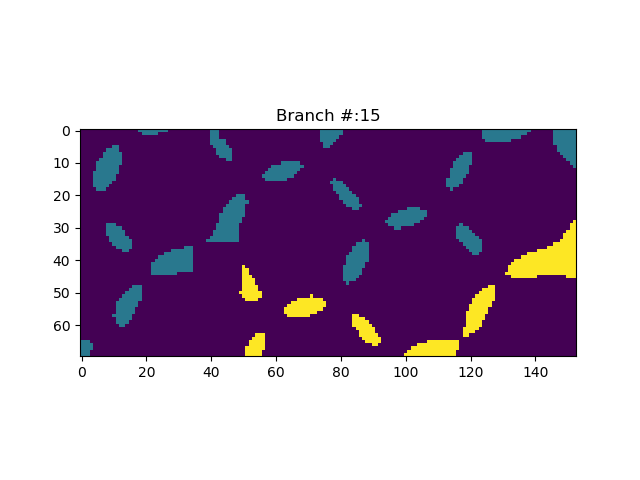

<IPython.core.display.Javascript object>


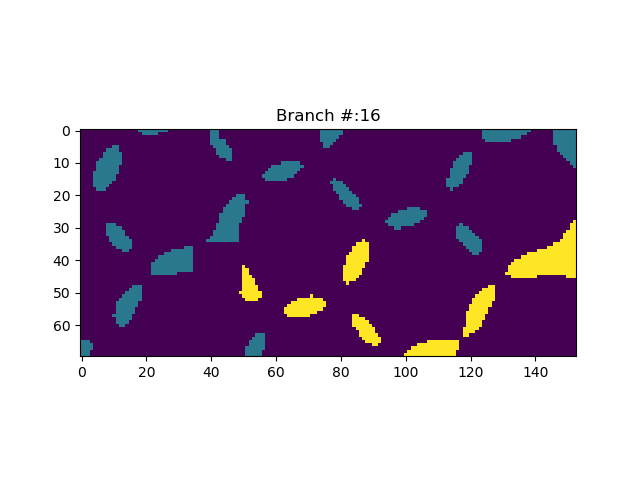

<IPython.core.display.Javascript object>


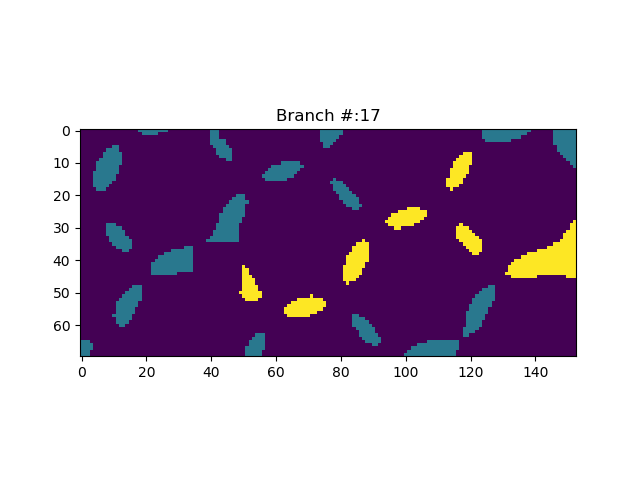

<IPython.core.display.Javascript object>


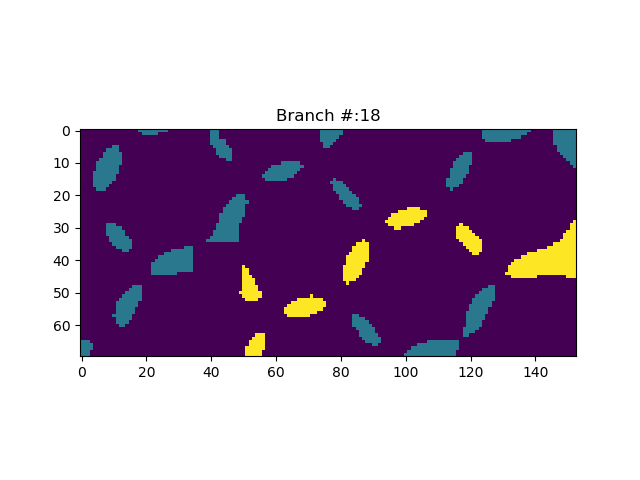

<IPython.core.display.Javascript object>


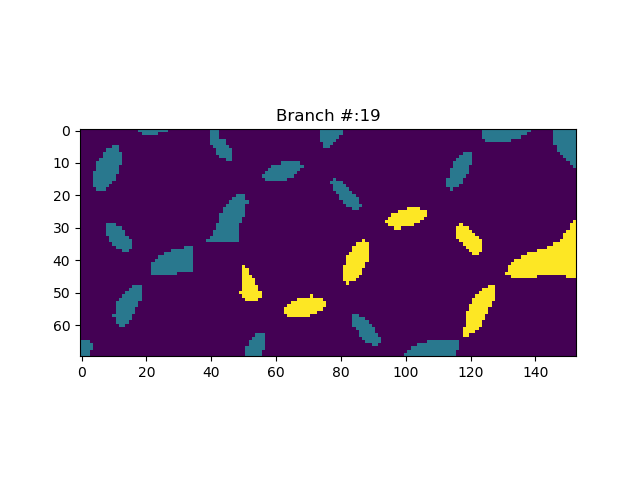

<IPython.core.display.Javascript object>


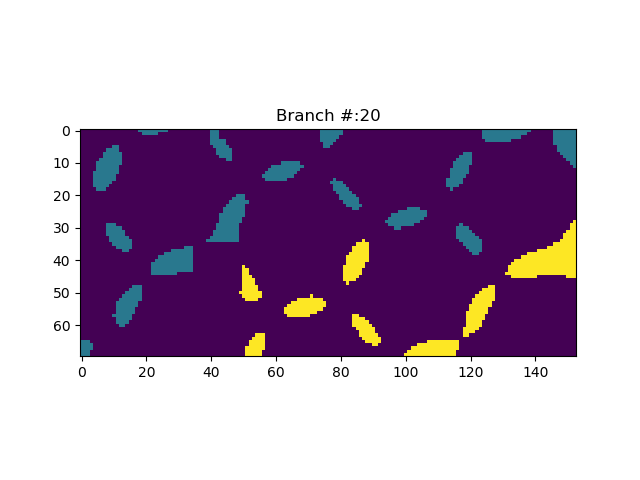

<IPython.core.display.Javascript object>


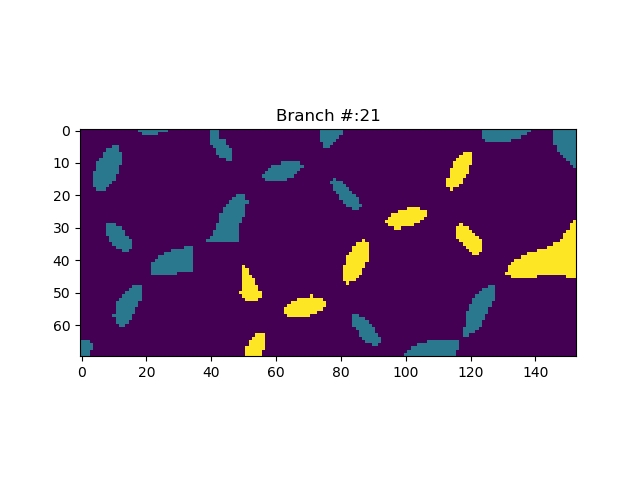

<IPython.core.display.Javascript object>


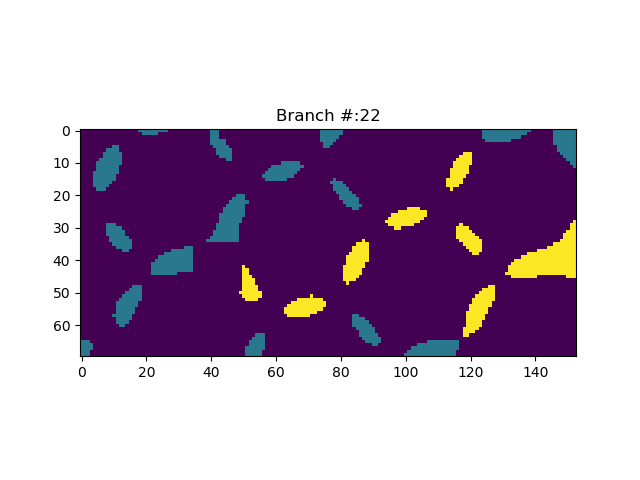

<IPython.core.display.Javascript object>


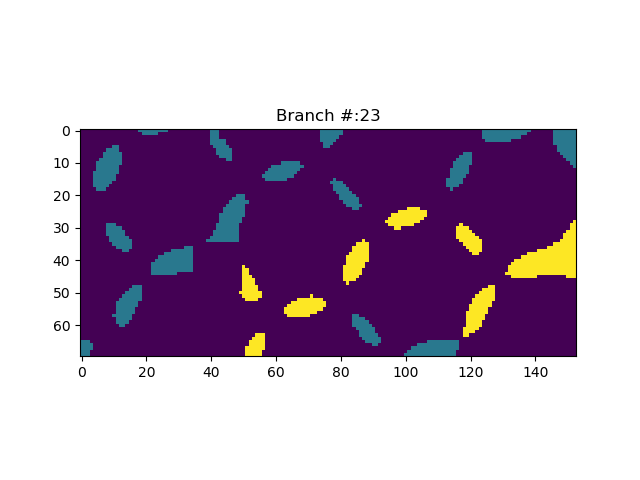

In [35]:
for i in range(len(filtered_branches)):
    again2 = modified_eroded.copy()
    for key in filtered_branches[i]:
        current_island = mod_dict[(key[0],key[1])]
        for coord in current_island:
            again2[coord[0], coord[1]] = 500
    plt.figure()
    titlestr = "Branch #:" + str(i + 1)
    plt.title(titlestr)
    plt.imshow(again2)

    plt.show()

In [36]:
# stackGsub: not cleaned
# stackGsubd: cleaned

### Adjusted code again to work with the cleaned image

dim = 15
hdim = int(dim/2)
spinon_count_from_sum = 0
spinon_count_from_avg = 0
sum_high_zero_count = 0
avg_high_zero_count = 0
sum_zero_count = 0
avg_zero_count = 0
zeros_fromavg = 0
### for modularity later; just name whatever final actual array and go below so i dont have to rename
#
# nodes = final_actual_array


In [37]:
### Re-defining the "stacks" to be pre-cleaning

# correct background with graussian filter
stackG = np.zeros(stack.shape)
for i in range(stack.shape[0]):
    stackG[i] = stack[i]*1.-gaussian_filter(stack[i],20)*1.
    stackG[i][stackG[i]<0] = 0
    
#choose area of interest
stackGsub = stackG[:,400:650,400:600]

Path # 1
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


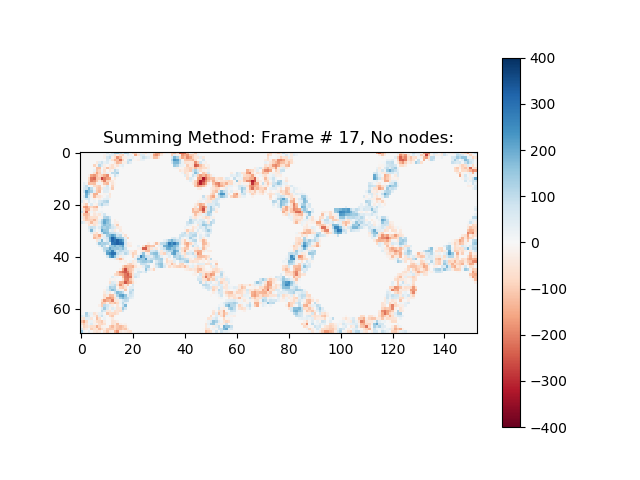

<IPython.core.display.Javascript object>


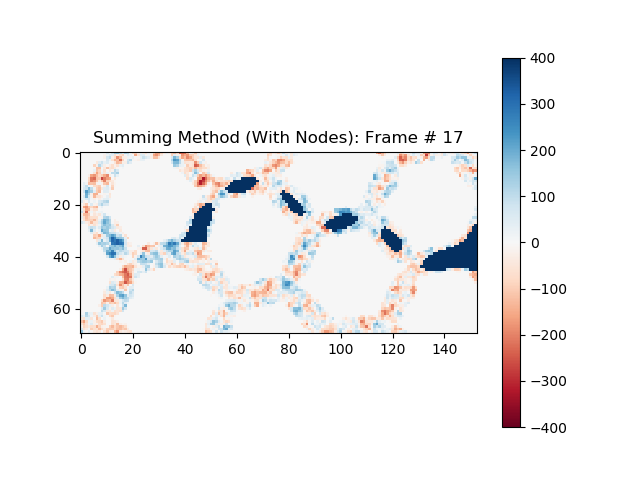

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 1
Total spinon count from Sum: 6
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 68
# Maps with Zeros from Averaging? 68
Path # 2
Total Results for Path # 2
Total spinon count from Sum: 6
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 138
# Maps with Zeros from Averaging? 138
Path # 3
Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 3
Total spinon count from Sum: 9
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 206
# Maps with Zeros from Averaging? 206
Path # 4
Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 4
Total spinon count from Sum: 10
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 281
# Maps with Zeros from Averaging? 281
Path # 5
Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 5
Total spinon count from Sum: 11
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 349
# Maps with Zeros from Averaging? 349
Path # 6
Total Results for Path # 6
Total spinon count from Sum: 11
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 425
# Maps with Zeros from Averaging? 425
Path # 7
Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 7
Total spinon count from Sum: 12
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 495
# Maps with Zeros from Averaging? 495
Path # 8
Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


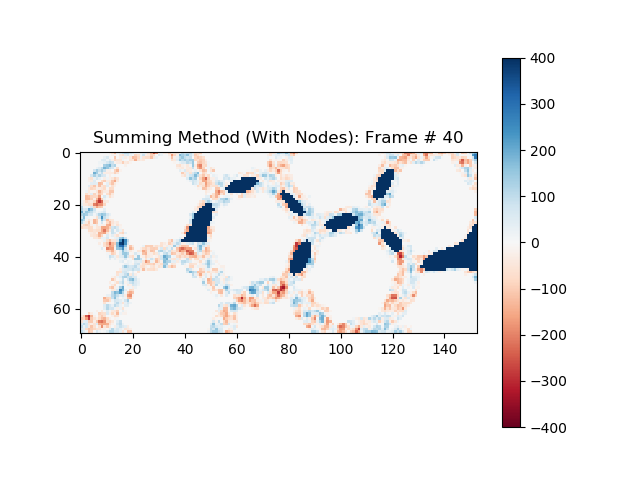

Total Results for Path # 8
Total spinon count from Sum: 14
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 565
# Maps with Zeros from Averaging? 565
Path # 9
Total Results for Path # 9
Total spinon count from Sum: 14
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 642
# Maps with Zeros from Averaging? 642
Path # 10
Total Results for Path # 10
Total spinon count from Sum: 14
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 717
# Maps with Zeros from Averaging? 717
Path # 11
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


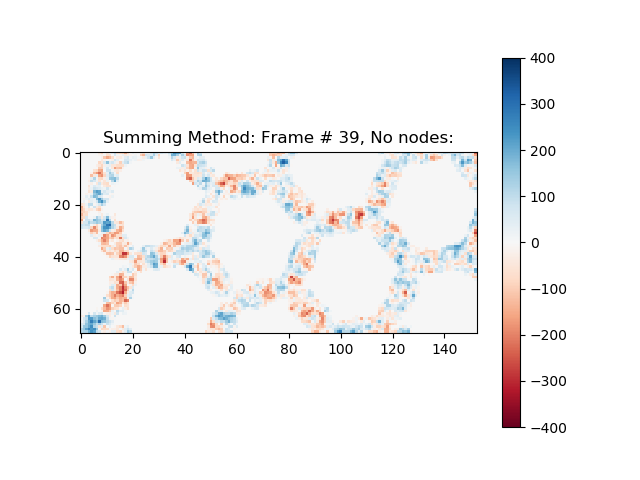

<IPython.core.display.Javascript object>


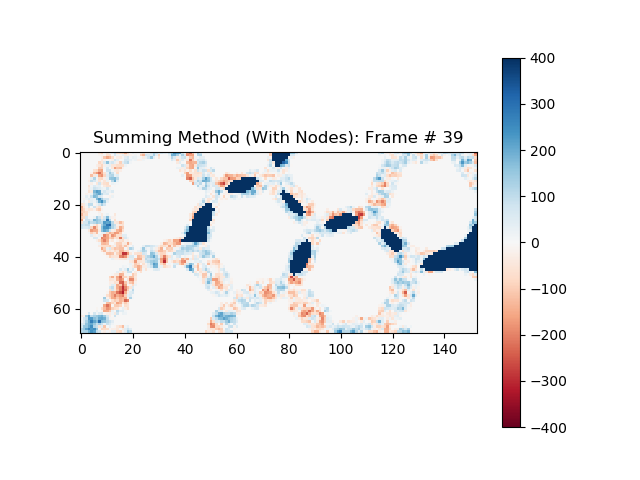

Total Results for Path # 11
Total spinon count from Sum: 15
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 785
# Maps with Zeros from Averaging? 785
Path # 12
Total Results for Path # 12
Total spinon count from Sum: 15
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 860
# Maps with Zeros from Averaging? 860
Path # 13
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


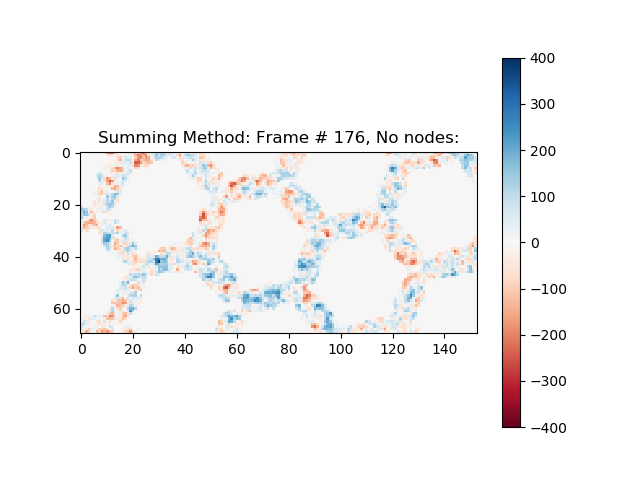

<IPython.core.display.Javascript object>


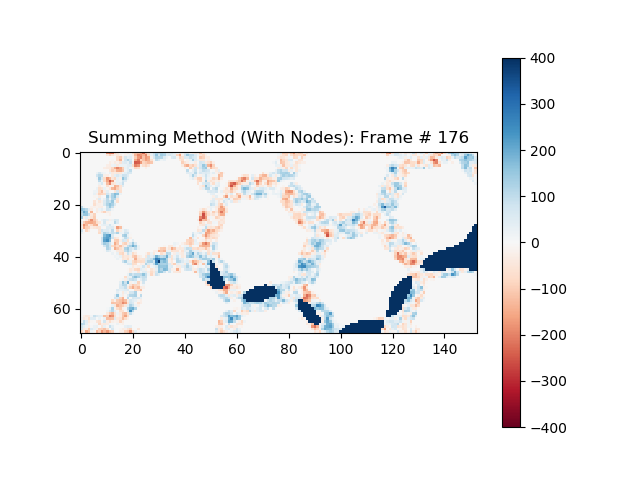

Total Results for Path # 13
Total spinon count from Sum: 16
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 904
# Maps with Zeros from Averaging? 904
Path # 14
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


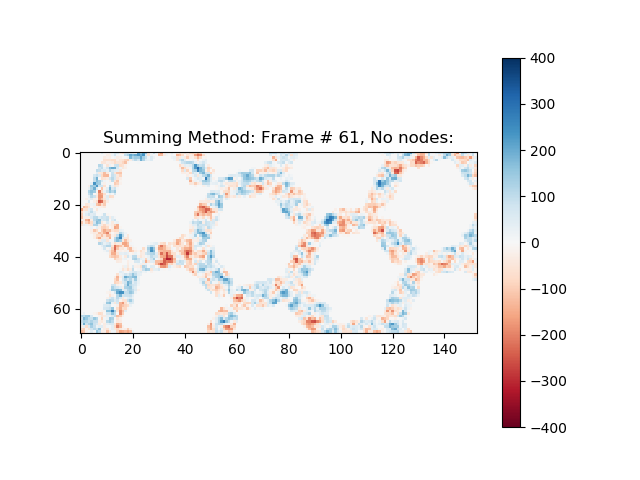

<IPython.core.display.Javascript object>


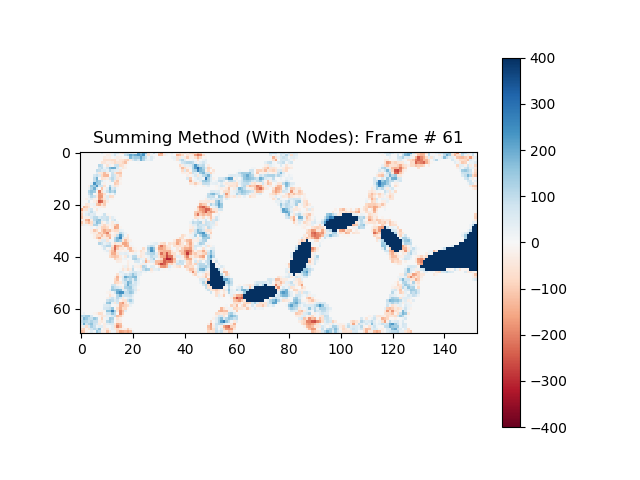

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


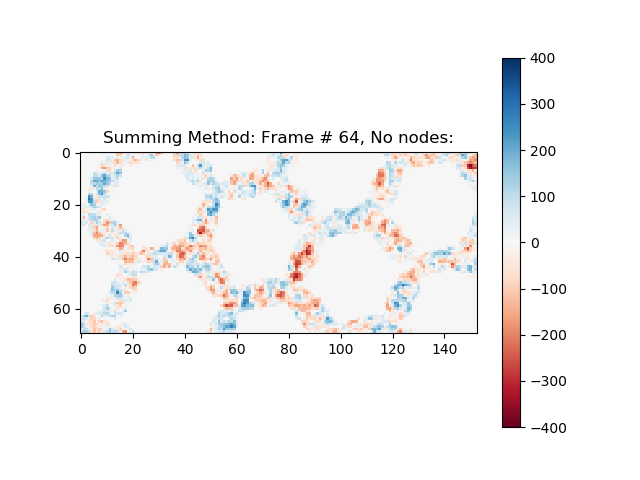

<IPython.core.display.Javascript object>


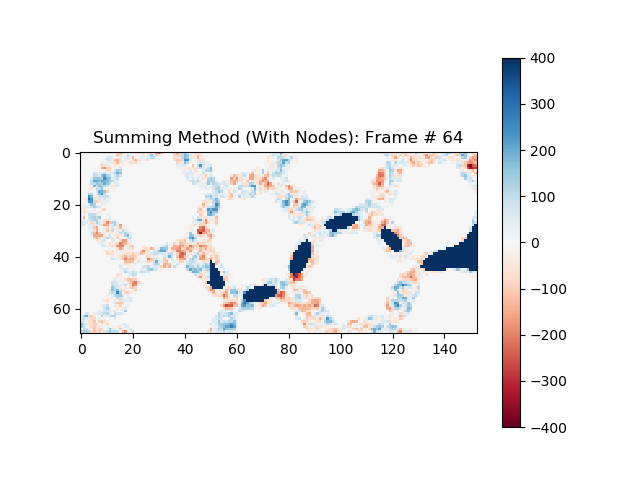

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


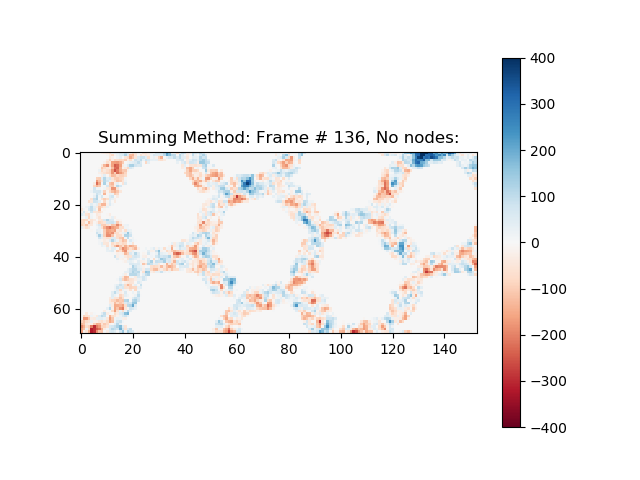

<IPython.core.display.Javascript object>


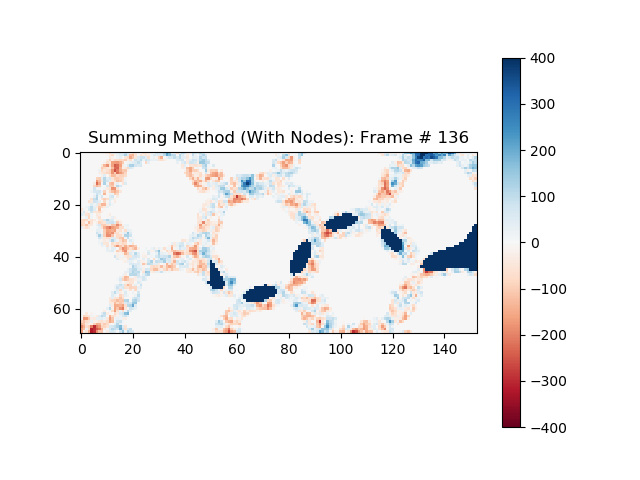

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


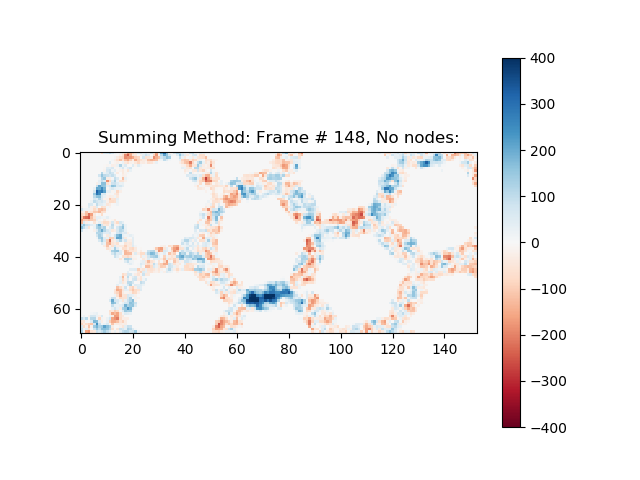

<IPython.core.display.Javascript object>


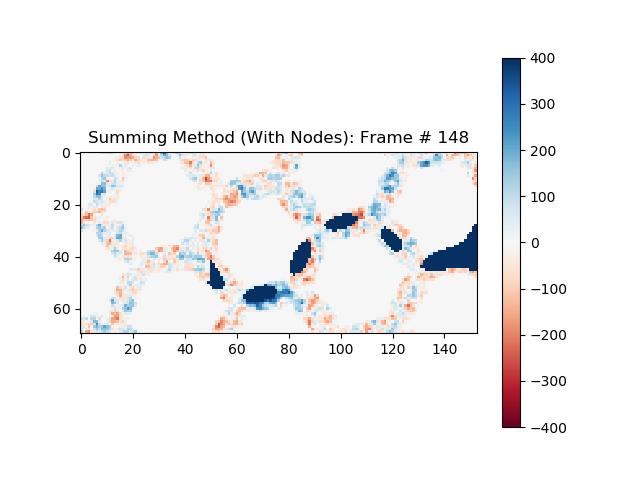

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


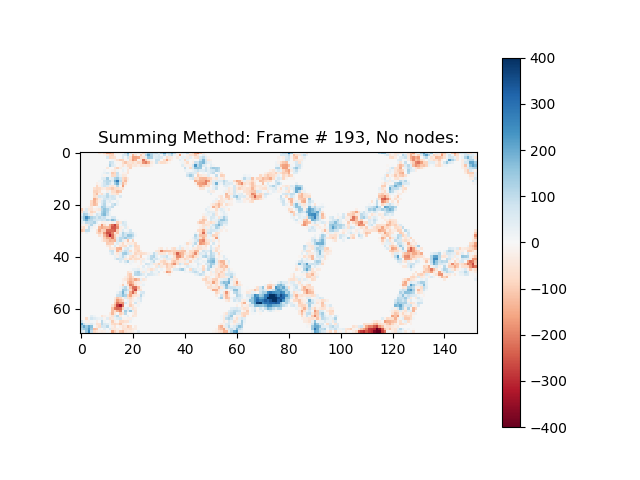

<IPython.core.display.Javascript object>


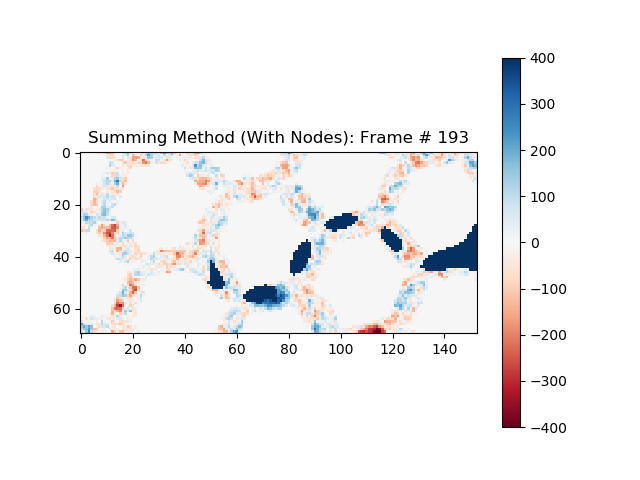

Total Results for Path # 14
Total spinon count from Sum: 21
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 911
# Maps with Zeros from Averaging? 911
Path # 15
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


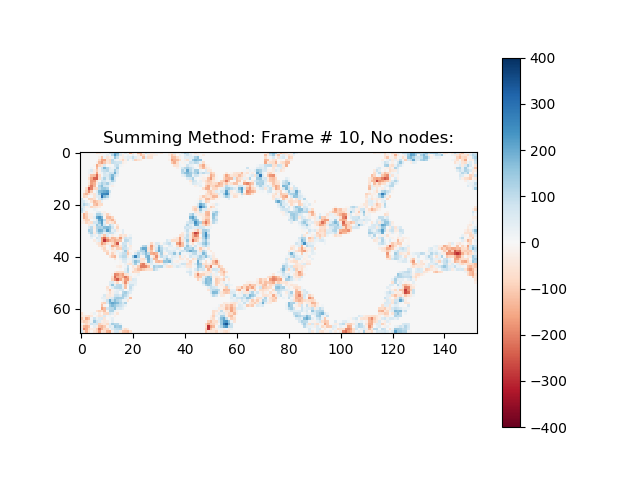

<IPython.core.display.Javascript object>


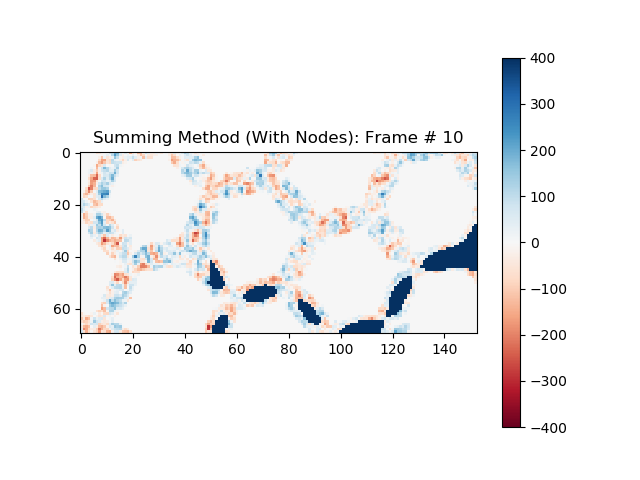

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


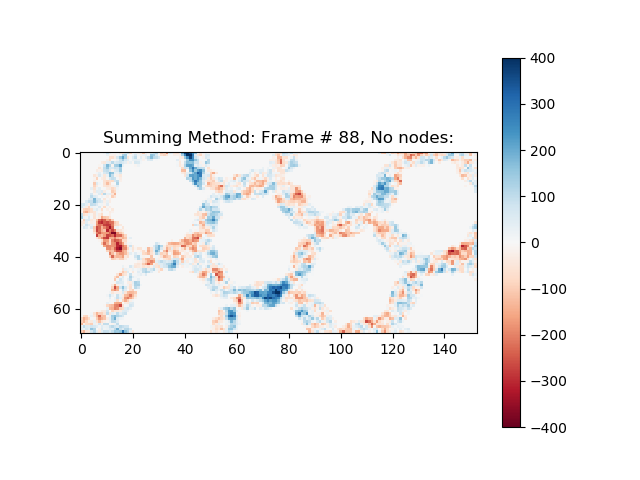

<IPython.core.display.Javascript object>


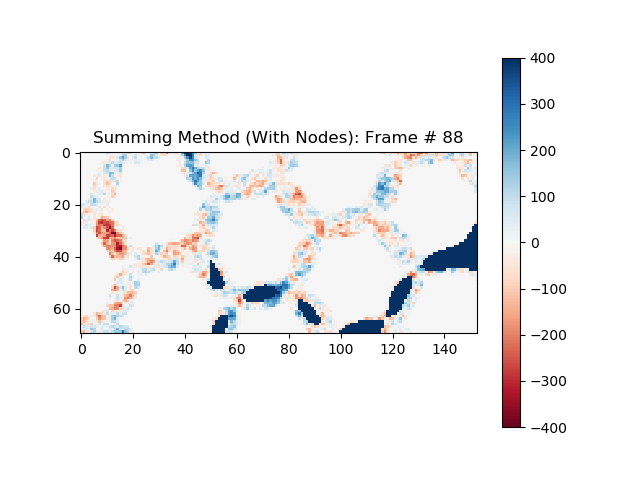

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


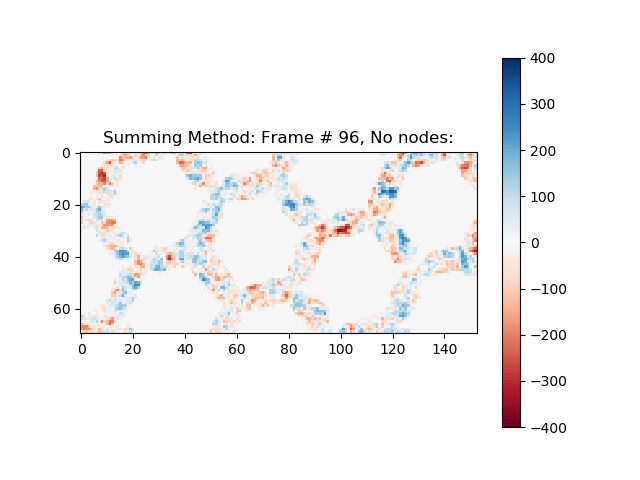

<IPython.core.display.Javascript object>


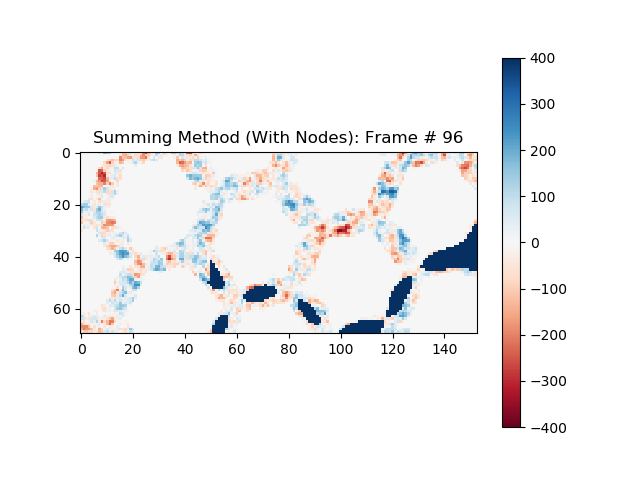

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


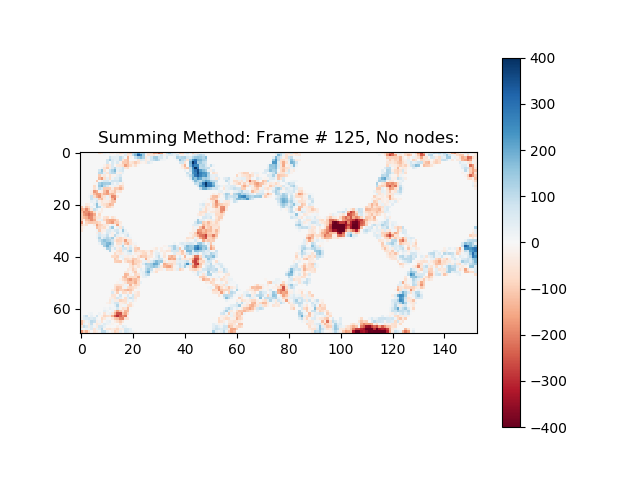

<IPython.core.display.Javascript object>


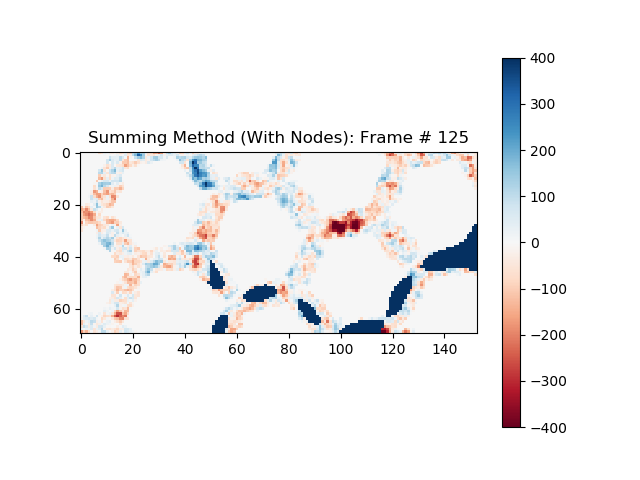

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


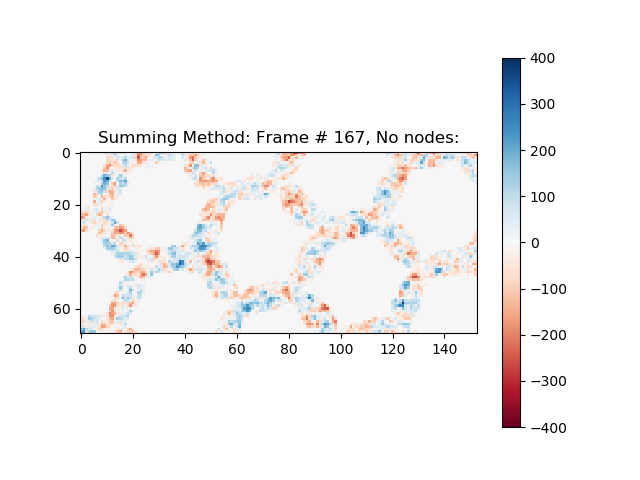

<IPython.core.display.Javascript object>


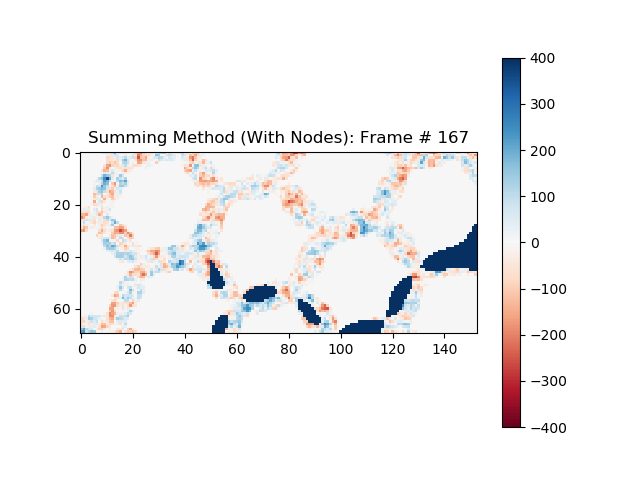

Total Results for Path # 15
Total spinon count from Sum: 26
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 955
# Maps with Zeros from Averaging? 955
Path # 16
Total Results for Path # 16
Total spinon count from Sum: 26
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1000
# Maps with Zeros from Averaging? 1000
Path # 17
Total Results for Path # 17
Total spinon count from Sum: 26
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1009
# Maps with Zeros from Averaging? 1009
Path # 18
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


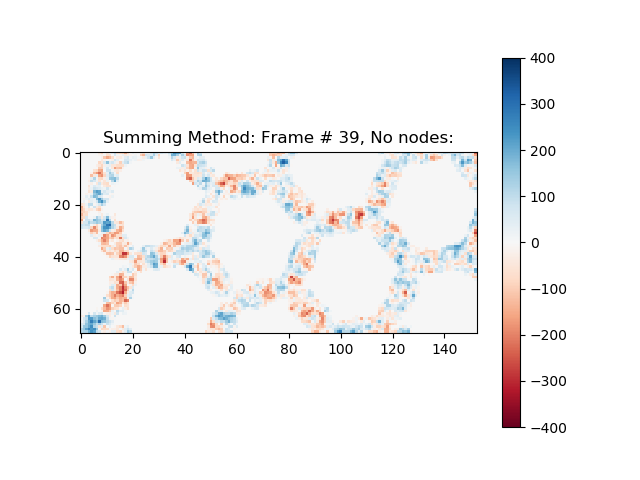

<IPython.core.display.Javascript object>


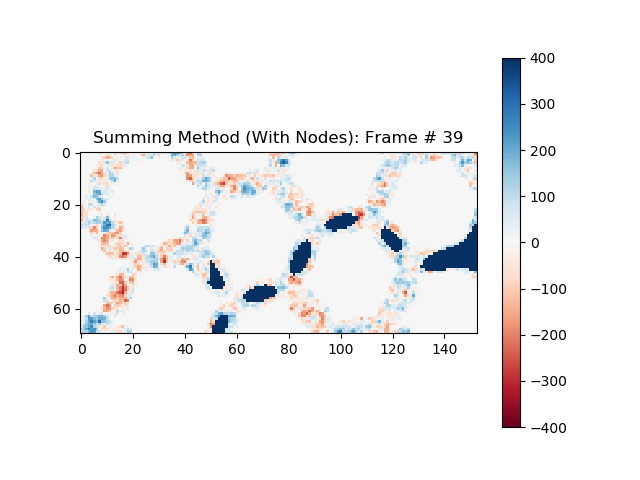

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


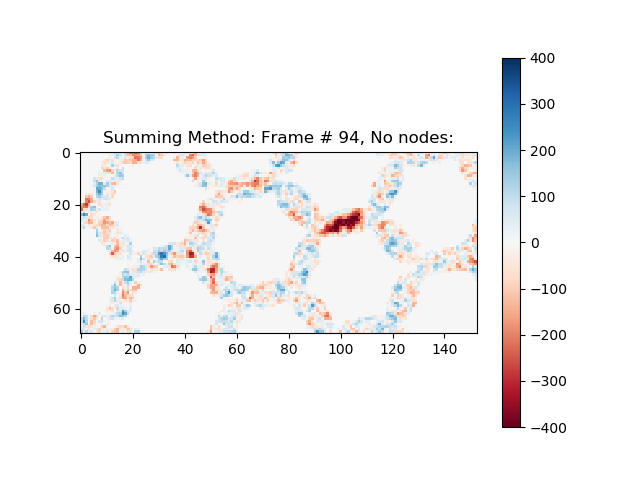

<IPython.core.display.Javascript object>


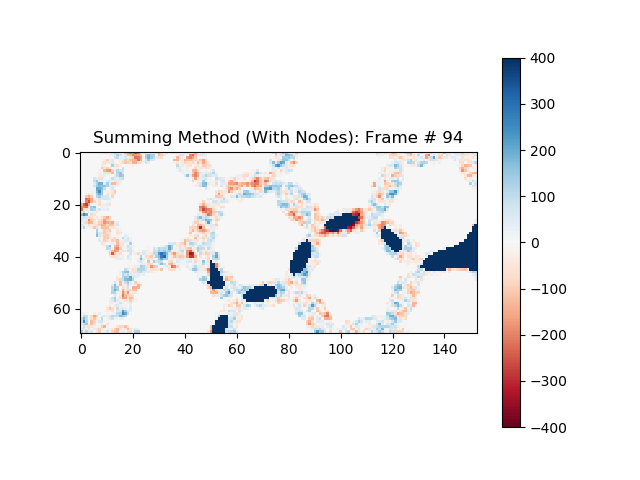

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


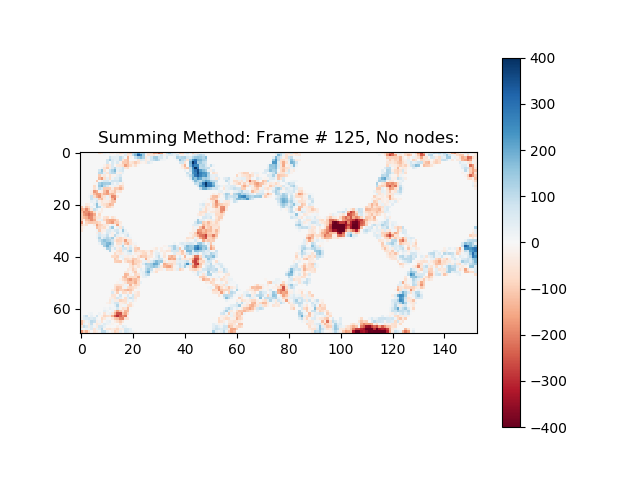

<IPython.core.display.Javascript object>


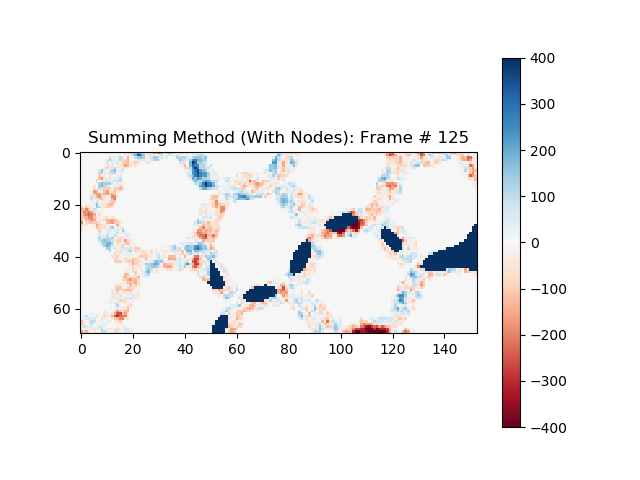

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


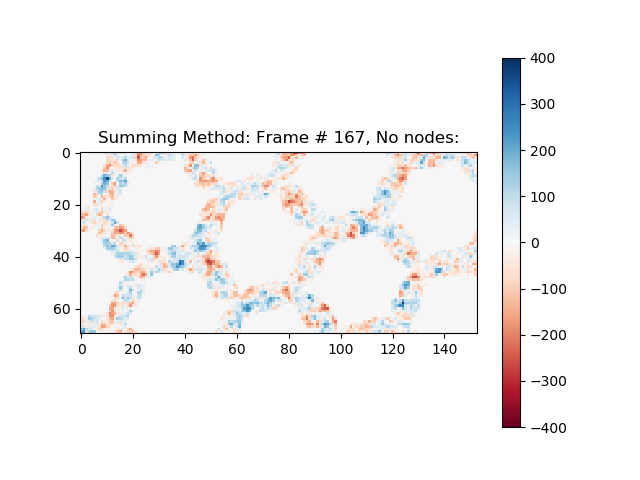

<IPython.core.display.Javascript object>


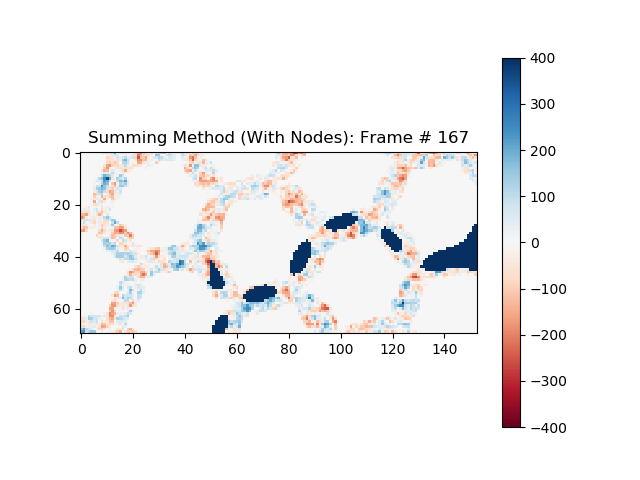

Total Results for Path # 18
Total spinon count from Sum: 30
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1016
# Maps with Zeros from Averaging? 1016
Path # 19
Total Results for Path # 19
Total spinon count from Sum: 30
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1060
# Maps with Zeros from Averaging? 1060
Path # 20
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


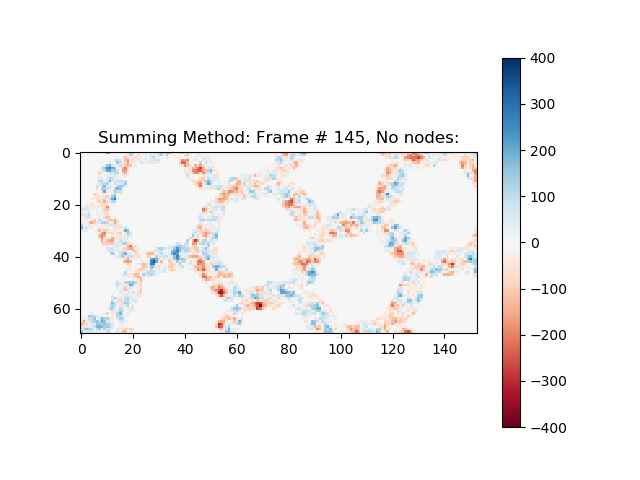

<IPython.core.display.Javascript object>


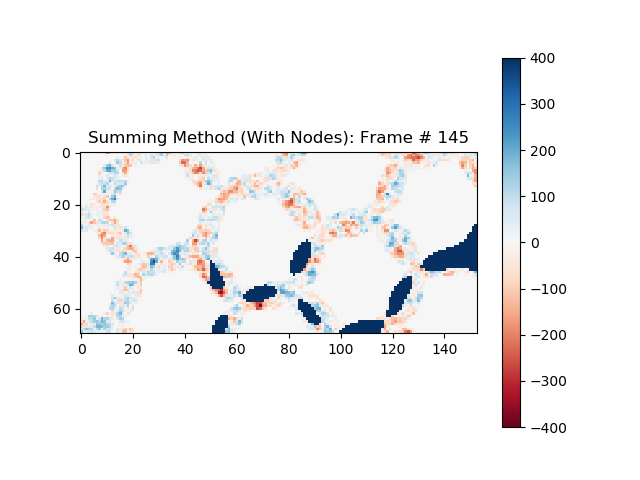

Total Results for Path # 20
Total spinon count from Sum: 31
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1105
# Maps with Zeros from Averaging? 1105
Path # 21
Spinon detected! Sum Method


<IPython.core.display.Javascript object>


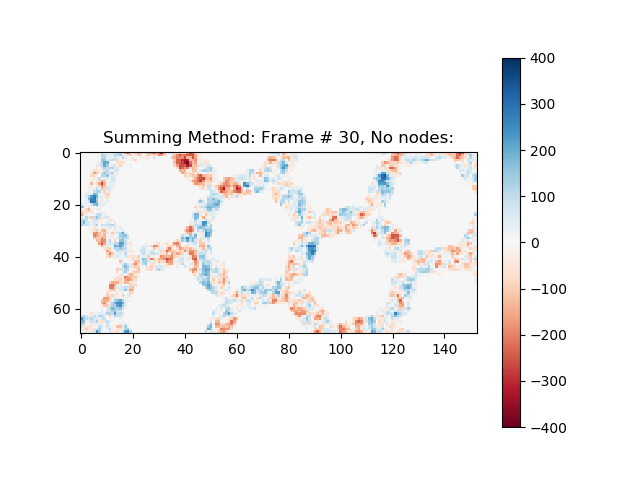

<IPython.core.display.Javascript object>


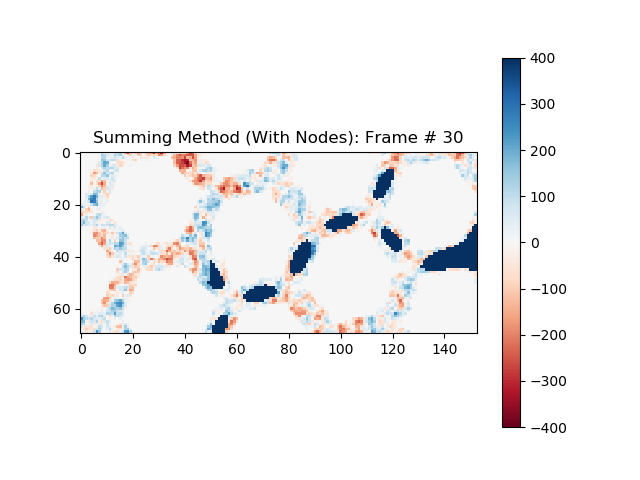

Spinon detected! Sum Method


<IPython.core.display.Javascript object>


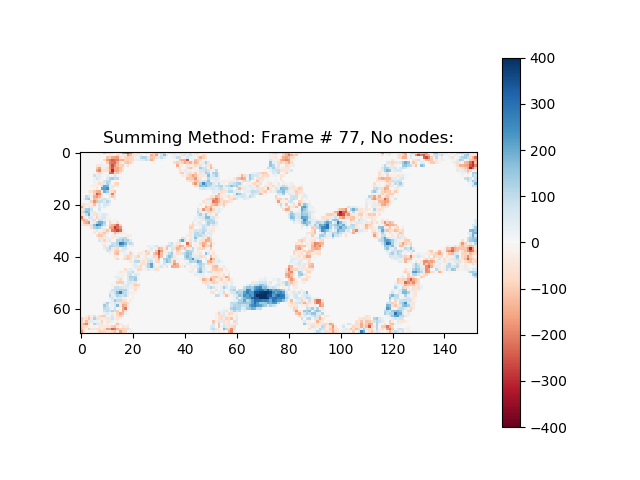

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 21
Total spinon count from Sum: 34
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1114
# Maps with Zeros from Averaging? 1114
Path # 22
Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 22
Total spinon count from Sum: 36
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1160
# Maps with Zeros from Averaging? 1160
Path # 23
Spinon detected! Sum Method


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Total Results for Path # 23
Total spinon count from Sum: 37
Total spinon count from Averaging: 0
# Maps with Zeros from Summing? 1204
# Maps with Zeros from Averaging? 1204


In [38]:
current_dict = mod_dict


sample_paths = filtered_branches


for k in range(len(sample_paths)):
    sample_path = sample_paths[k]
    print('Path #', str(k+1))
    
    for i in range(1,(len(stackGsub))):
        #print("Current_Progress: ", i)

        # stackGsub: need subtractions
        # stackGsubd: cleaned, but subtractions already performed

        red_stack = stackGsub[i][(startx - margin):(endx + margin), (starty - margin):(endy + margin)]
        prev_stack = stackGsub[i-1][(startx - margin):(endx + margin), (starty - margin):(endy + margin)]
        diff_stack = red_stack - prev_stack
        diff_plot = diff_stack.copy()
        #stack_plot = red_stack.copy()
        spins = []
        sums = []

        avgs = []
        avgspins = []

        path = sample_path

        for key in path:
            current_coords = current_dict[(key[0], key[1])]
            for coord in current_coords:
                stack_node = diff_stack[coord[0], coord[1]] 
                diff_plot[coord[0], coord[1]] = 500

            node_sum = np.sum(stack_node)
            sums.append(node_sum)

            node_avg = np.average(stack_node)
            avgs.append(node_avg)

    #         print('sums:', sums)
    #         print("averages:", avgs)

        sumzeros = 0

        # Sum method:

        for sumval in sums:
            if sumval > 0:
                spins.append(1)
            elif sumval < 0:
                spins.append(-1)
            else:
                spins.append(0)
                sumzeros += 1

        # Average Method:

        avgzeros = 0

        for avg in avgs:
            if avg > 0:
                avgspins.append(1)
            elif avg < 0:
                avgspins.append(-1)
            else:
                avgspins.append(0)
                avgzeros += 1


        if sumzeros > 0:
            sum_zero_count += 1
            if sumzeros >= 3:
                sum_high_zero_count += 1
                #print("High Zero Count (Sum)")

        if avgzeros > 0:
            avg_zero_count += 1
            if avgzeros >= 3:
                avg_high_zero_count += 1
                #print("High Zero Count (Avg)")

        #print("Islands' spin on this frame: ", spins)

        flips = []
        avgflips = []
        for j in range(1,len(spins)):
            sign_flip = (spins[j-1] == -1*spins[j])
            avgsign_flip = (avgspins[j-1] == -1*avgspins[j])
            flips.append(sign_flip)
            avgflips.append(avgsign_flip)

        if np.all(flips):
            print("Spinon detected! Sum Method")
    #             print(sums)
    #             print(spins)
    #             print(flips)
            spinon_count_from_sum += 1
            str_title = "Summing Method: Frame # " + str(i)
            plt.figure()
            plt.title(str_title + ', No nodes:')
            plt.imshow(diff_stack, cmap = 'RdBu', vmin = -400, vmax = 400)
            plt.colorbar()

            plt.figure()
            st2 = "Summing Method (With Nodes): Frame # " + str(i)
            plt.title(st2)
            plt.imshow(diff_plot, cmap = 'RdBu', vmin = -400, vmax = 400)
            plt.colorbar()

#         if np.all(avgflips):
#             print("Spinon detected! Average Method")
# #             print(avgs)
# #             print(avgspins)
# #             print(avgflips)
#             spinon_count_from_avg += 1
#             str_title = "Averaging Method: Frame # = " + str(i)
#             plt.figure()
#             plt.title(str_title + ', No nodes:')
#             plt.imshow(diff_stack, cmap = 'RdBu', vmin = -400, vmax = 400)
#             plt.colorbar()

#             plt.figure()
#             st2 = "Averaging Method (With Nodes): Frame # " + str(i)
#             plt.title(st2)
#             plt.imshow(diff_plot, cmap = 'RdBu', vmin = -400, vmax = 400)
#             plt.colorbar()
    
    print('Total Results for Path #', str(k+1))
    print('Total spinon count from Sum:', spinon_count_from_sum)
    print('Total spinon count from Averaging:', spinon_count_from_avg)
    print("# Maps with Zeros from Summing?", sum_zero_count)
    print("# Maps with Zeros from Averaging?", avg_zero_count)

plt.show()

## Create movie

In [39]:
#make movie
stackGsubds = stackGsubd[:100]

fig = plt.figure(figsize = (6,6))
#binPimages = np.log(binPimages)

im = plt.imshow((lattice+stackGsubds[1]),cmap = 'RdBu', vmin = -500, vmax = 500)
plt.colorbar()
#plt.annotate('t = '+str(i),xy=(0,0), xytext=(15,30), fontsize=20)

def init():
    im.set_data(lattice+stackGsubds[1])
    return im

# animation function.  This is called sequentially
def animate(i):
    im.set_array((lattice+stackGsubds[i]))
    #plt.title('t = '+str(i),xy=(0,0), xytext=(15,30), fontsize=20)
    return im

ani = animation.FuncAnimation(fig, animate,init_func=init)
#writer = animation.writers['ffmpeg'](fps=30)
#animation.writers['ffmpeg']
fig.show()




<IPython.core.display.Javascript object>